# Box office Prediction


## Project definition:

To try and build a model to predict for a given movie its overall worldwide Box Office revenue.
The data set includes past movies with information about them including the cast, the director, plot keywords… And of course, for the training data points we have the classification (total Box office revenue)

## Data Exploration:

First step to start with is always to explore the data set we are given. This will include independently analyzing each of the features, finding correlations between them, dimensionality reduction and feature selection.

In [1]:
import pandas as pd
pd.set_option('max_columns', None)
import numpy as np
import ast
import matplotlib.pyplot as plt
import math

### Features:

The features we have in the data set are:

In [2]:
train_set = pd.read_csv('data/train.csv')
test_set = pd.read_csv('data/test.csv')
train_set.columns

Index([u'id', u'belongs_to_collection', u'budget', u'genres', u'homepage',
       u'imdb_id', u'original_language', u'original_title', u'overview',
       u'popularity', u'poster_path', u'production_companies',
       u'production_countries', u'release_date', u'runtime',
       u'spoken_languages', u'status', u'tagline', u'title', u'Keywords',
       u'cast', u'crew', u'revenue'],
      dtype='object')

Some of these features have strings values, 
others are lists of dictionaries displayed as strings.
We will convert these features to python dictionaries for ease of access.

In [3]:
LIST_COLS = ['belongs_to_collection', 'genres', 'production_companies',
                'production_countries', 'spoken_languages', 'Keywords', 'cast', 'crew']

def convert_text_cols_to_list(df):
    for col in LIST_COLS:
        df[col] = [{} if pd.isna(value) else ast.literal_eval(value) for value in df[col]]
    return df

train_set = convert_text_cols_to_list(train_set)
test_set = convert_text_cols_to_list(test_set)

In [4]:
train_set.head(2)

id                              belongs_to_collection    budget  \
0   1  [{u'backdrop_path': u'/noeTVcgpBiD48fDjFVic1Vz...  14000000   
1   2  [{u'backdrop_path': u'/zSEtYD77pKRJlUPx34BJgUG...  40000000   

                                              genres homepage    imdb_id  \
0                  [{u'id': 35, u'name': u'Comedy'}]      NaN  tt2637294   
1  [{u'id': 35, u'name': u'Comedy'}, {u'id': 18, ...      NaN  tt0368933   

  original_language                            original_title  \
0                en                    Hot Tub Time Machine 2   
1                en  The Princess Diaries 2: Royal Engagement   

                                            overview  popularity  \
0  When Lou, who has become the "father of the In...    6.575393   
1  Mia Thermopolis is now a college graduate and ...    8.248895   

                        poster_path  \
0  /tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg   
1  /w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg   

                                production_companies  \
0  [{u'name': u'Paramount Pictures', u'id': 4}, {...   
1     [{u'name': u'Walt Disney Pictures', u'id': 2}]   

                                production_countries release_date  runtime  \
0  [{u'iso_3166_1': u'US', u'name': u'United Stat...      2/20/15     93.0   
1  [{u'iso_3166_1': u'US', u'name': u'United Stat...       8/6/04    113.0   

                               spoken_languages    status  \
0  [{u'iso_639_1': u'en', u'name': u'English'}]  Released   
1  [{u'iso_639_1': u'en', u'name': u'English'}]  Released   

                                             tagline  \
0  The Laws of Space and Time are About to be Vio...   
1  It can take a lifetime to find true love; she'...   

                                      title  \
0                    Hot Tub Time Machine 2   
1  The Princess Diaries 2: Royal Engagement   

                                            Keywords  \
0  [{u'id': 4379, u'name': u'time travel'}, {u'id...   
1  [{u'id': 2505, u'name': u'coronation'}, {u'id'...   

                                                cast  \
0  [{u'name': u'Rob Corddry', u'gender': 2, u'cha...   
1  [{u'name': u'Anne Hathaway', u'gender': 1, u'c...   

                                                crew   revenue  
0  [{u'name': u'Kelly Cantley', u'gender': 0, u'd...  12314651  
1  [{u'name': u'Garry Marshall', u'gender': 2, u'...  95149435

Now we’ll go through each of these features and analyze their potentional contribution to the classification/their correlations with other features, and possibly construct new features using the existing ones

#### i.	Genres feature:
As we can see from the table above, movies might belong to more than one genre, the values for this feature are a list which its elements are dictionaries with a genre id and a genre name. for example the movie with the id 2 belongs to genres Comedy (genre id 35), Drama(genre id 18), Family (genre id 10751) and Romance (genre id 10749).
	


In [5]:
train_set["genres"][1]

[{'id': 35, 'name': 'Comedy'},
 {'id': 18, 'name': 'Drama'},
 {'id': 10751, 'name': 'Family'},
 {'id': 10749, 'name': 'Romance'}]

The genre id will probably not be helpful for extracting information about the movie, it is just an overhead. 
We could use the genre id *instead* of using the genre name, we prefer to use the names since it is easier to comprehend.

Since we can’t define any order for genres, a good approach for dealing with such a nominal feature is to transform it to a group of “dummy” binary features. I.e. each feature will indicate whether or not the movie belongs to the specific genre.
For example: The movie with the id 2 will have the value 1 for the newly constructed features genre_name_comedy, genre_name_drama, genre_name_family and genre_name_romance, and 0 in all the other “genre_name_” feature.

In [6]:
genre_names_with_repetions = list(x["name"] for l in train_set["genres"] for x in l)
genre_names_with_repetions

['Comedy',
 'Comedy',
 'Drama',
 'Family',
 'Romance',
 'Drama',
 'Thriller',
 'Drama',
 'Action',
 'Thriller',
 'Animation',
 'Adventure',
 'Family',
 'Horror',
 'Thriller',
 'Documentary',
 'Action',
 'Comedy',
 'Music',
 'Family',
 'Adventure',
 'Comedy',
 'Music',
 'Drama',
 'Comedy',
 'Drama',
 'Comedy',
 'Crime',
 'Action',
 'Thriller',
 'Science Fiction',
 'Mystery',
 'Action',
 'Crime',
 'Drama',
 'Horror',
 'Thriller',
 'Drama',
 'Romance',
 'Comedy',
 'Romance',
 'Action',
 'Thriller',
 'Crime',
 'Adventure',
 'Family',
 'Science Fiction',
 'Horror',
 'Thriller',
 'Thriller',
 'Horror',
 'Thriller',
 'Mystery',
 'Foreign',
 'Horror',
 'Comedy',
 'Comedy',
 'Horror',
 'Mystery',
 'Thriller',
 'Crime',
 'Drama',
 'Mystery',
 'Thriller',
 'Drama',
 'Comedy',
 'Romance',
 'Animation',
 'Action',
 'Adventure',
 'Crime',
 'Thriller',
 'Drama',
 'Comedy',
 'Mystery',
 'Drama',
 'Thriller',
 'Fantasy',
 'Action',
 'Adventure',
 'Horror',
 'Action',
 'Comedy',
 'Crime',
 'Thriller',
 

Just before we jump into constructing the new dummy features, let's have a look at the popularity of each genre.

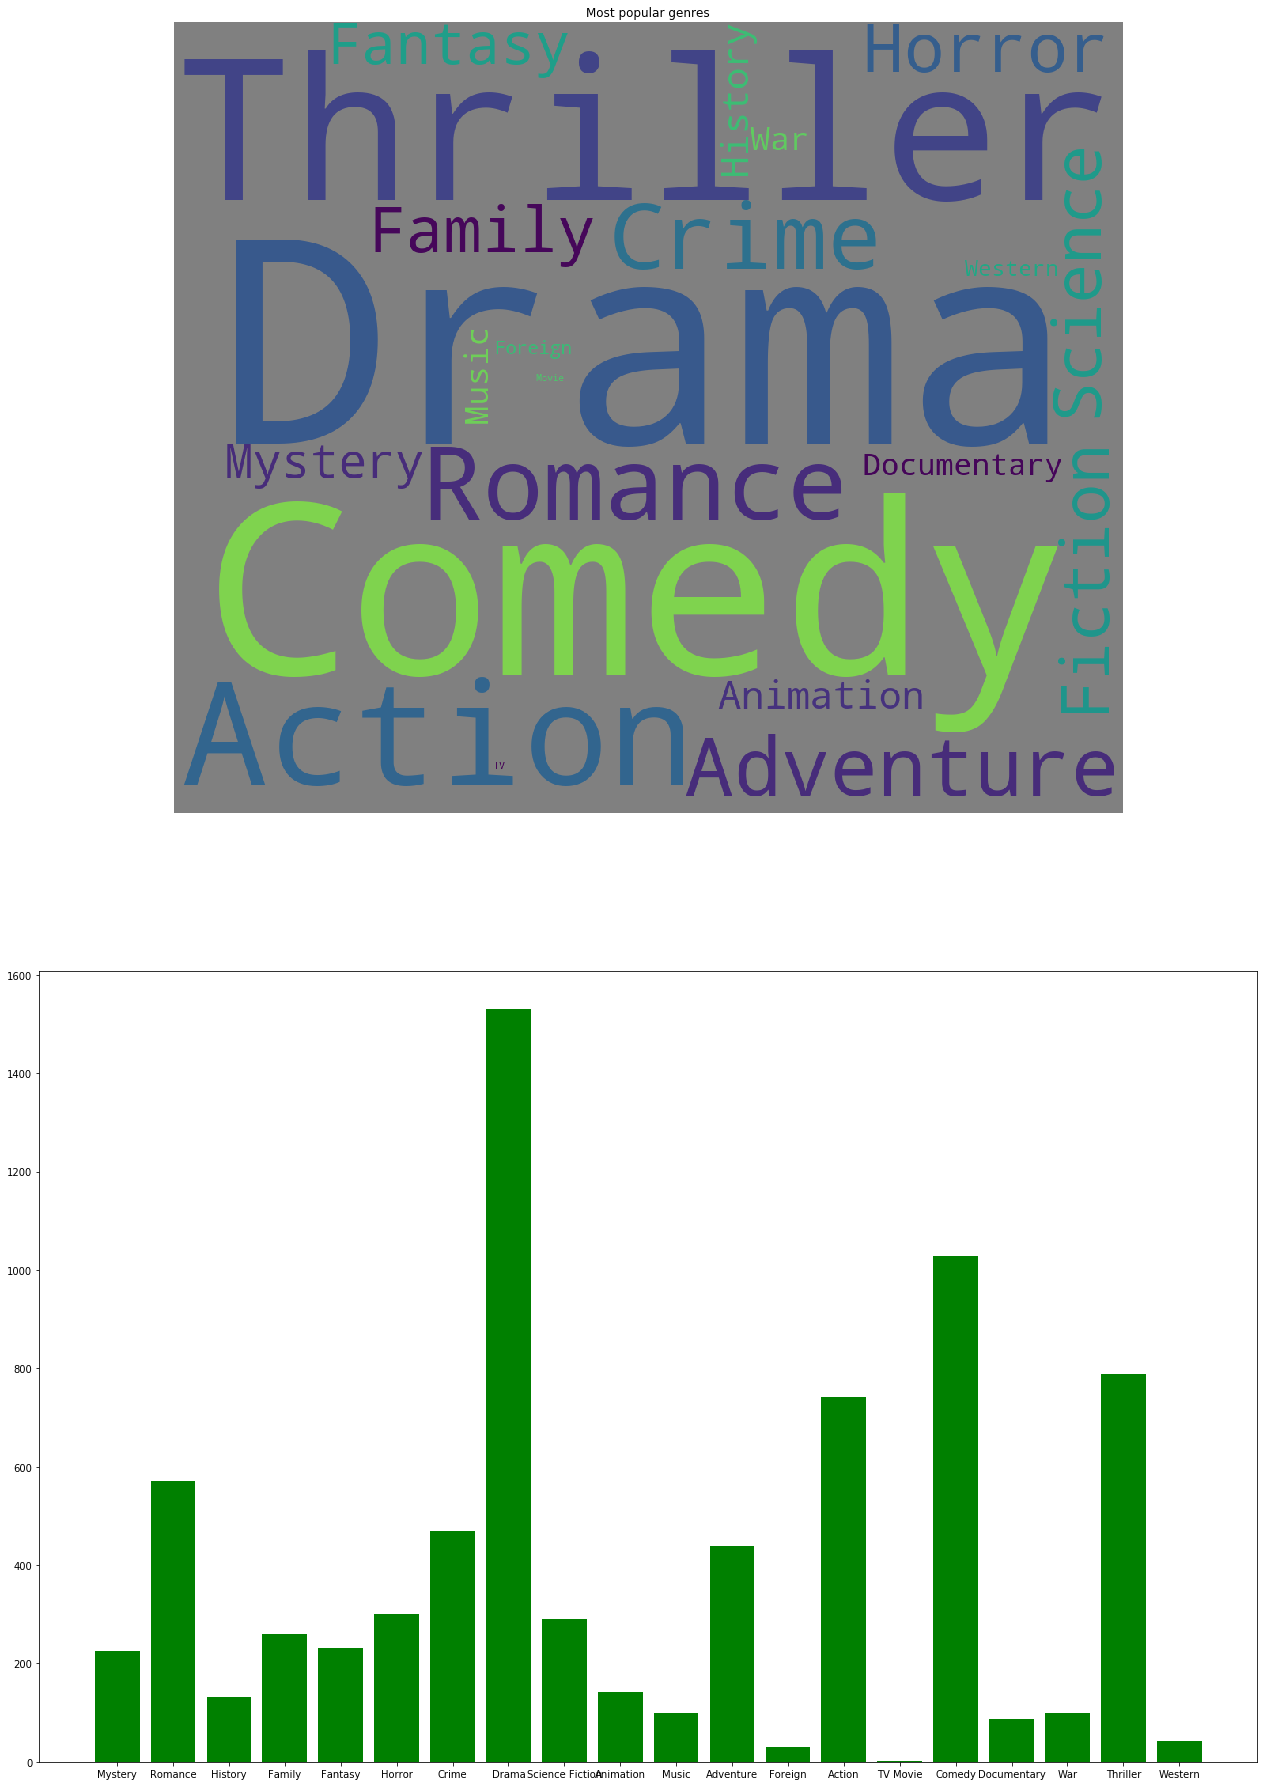

In [7]:
from wordcloud import WordCloud

plt.figure(figsize = (48, 32))
text = ' '.join([i for i in genre_names_with_repetions])

wordcloud = WordCloud(max_font_size=None, background_color='grey', collocations=False,
                      width=1200, height=1000).generate(text)
plt.subplot(2, 2, 1)
plt.imshow(wordcloud)
plt.title('Most popular genres')
plt.axis("off")

genre_names_popularity = {}
for genre in genre_names_with_repetions:
    if genre in genre_names_popularity.keys():
        continue
    genre_names_popularity[genre] = genre_names_with_repetions.count(genre)

plt.subplot(2, 2, 3)   
plt.bar(genre_names_popularity.keys(), genre_names_popularity.values(), color='g')

plt.show()

We can see that genres such like "TV Movie", "Foreign", "Western" and "Documentary" have very few appearences in comparison to other genres. We think it is safe to identify those genres as "outliers", in a sense that there is not enough data in the training set to rely on, when trying to find a difference between a movie that does belong to the "TV Movie" genre, for example, and another that doesn't.
In fact, there is only one movie that belongs to this genre, and this might be an enough of a reason for our model to determine the revenue of any movie that belongs to this genre, although it can not learn much about movies from this genre based only a single data point.

So in order to remain on the safe side and not to over-fit our model, we will create the new dummy features based only on genres that have more than 100 appearences. Other genres won't be taken into consideration for creating our model.

In [8]:
MOST_POPULAR_GENRES = [genre for genre in genre_names_popularity.keys() if genre_names_popularity[genre]>=100]
def convert_genre_feature_to_dummy_features(df):
    for genre_name in MOST_POPULAR_GENRES:
        df["genre_name_"+genre_name] = [1 if genre_name in str(l) else 0
                                           for l in df["genres"]]
        
convert_genre_feature_to_dummy_features(train_set)
convert_genre_feature_to_dummy_features(test_set)
train_set.head(2)

id                              belongs_to_collection    budget  \
0   1  [{u'backdrop_path': u'/noeTVcgpBiD48fDjFVic1Vz...  14000000   
1   2  [{u'backdrop_path': u'/zSEtYD77pKRJlUPx34BJgUG...  40000000   

                                              genres homepage    imdb_id  \
0                  [{u'id': 35, u'name': u'Comedy'}]      NaN  tt2637294   
1  [{u'id': 35, u'name': u'Comedy'}, {u'id': 18, ...      NaN  tt0368933   

  original_language                            original_title  \
0                en                    Hot Tub Time Machine 2   
1                en  The Princess Diaries 2: Royal Engagement   

                                            overview  popularity  \
0  When Lou, who has become the "father of the In...    6.575393   
1  Mia Thermopolis is now a college graduate and ...    8.248895   

                        poster_path  \
0  /tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg   
1  /w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg   

                                production_companies  \
0  [{u'name': u'Paramount Pictures', u'id': 4}, {...   
1     [{u'name': u'Walt Disney Pictures', u'id': 2}]   

                                production_countries release_date  runtime  \
0  [{u'iso_3166_1': u'US', u'name': u'United Stat...      2/20/15     93.0   
1  [{u'iso_3166_1': u'US', u'name': u'United Stat...       8/6/04    113.0   

                               spoken_languages    status  \
0  [{u'iso_639_1': u'en', u'name': u'English'}]  Released   
1  [{u'iso_639_1': u'en', u'name': u'English'}]  Released   

                                             tagline  \
0  The Laws of Space and Time are About to be Vio...   
1  It can take a lifetime to find true love; she'...   

                                      title  \
0                    Hot Tub Time Machine 2   
1  The Princess Diaries 2: Royal Engagement   

                                            Keywords  \
0  [{u'id': 4379, u'name': u'time travel'}, {u'id...   
1  [{u'id': 2505, u'name': u'coronation'}, {u'id'...   

                                                cast  \
0  [{u'name': u'Rob Corddry', u'gender': 2, u'cha...   
1  [{u'name': u'Anne Hathaway', u'gender': 1, u'c...   

                                                crew   revenue  \
0  [{u'name': u'Kelly Cantley', u'gender': 0, u'd...  12314651   
1  [{u'name': u'Garry Marshall', u'gender': 2, u'...  95149435   

   genre_name_Mystery  genre_name_Romance  genre_name_History  \
0                   0                   0                   0   
1                   0                   1                   0   

   genre_name_Family  genre_name_Fantasy  genre_name_Horror  genre_name_Crime  \
0                  0                   0                  0                 0   
1                  1                   0                  0                 0   

   genre_name_Drama  genre_name_Science Fiction  genre_name_Animation  \
0                 0                           0                     0   
1                 1                           0                     0   

   genre_name_Music  genre_name_Adventure  genre_name_Action  \
0                 0                     0                  0   
1                 0                     0                  0   

   genre_name_Comedy  genre_name_War  genre_name_Thriller  
0                  1               0                    0  
1                  1               0                    0

We can see for example, the first two movies have the correct vectors to descripe their genres.


Another interesting aspect to view the "genre" feature from is the number of genres for each movie.
To demonstrate that let's add this feature to our data and plot the relation between the number of generes and the total revenue.

Text(0.5,1,'# of genres vs revenue')

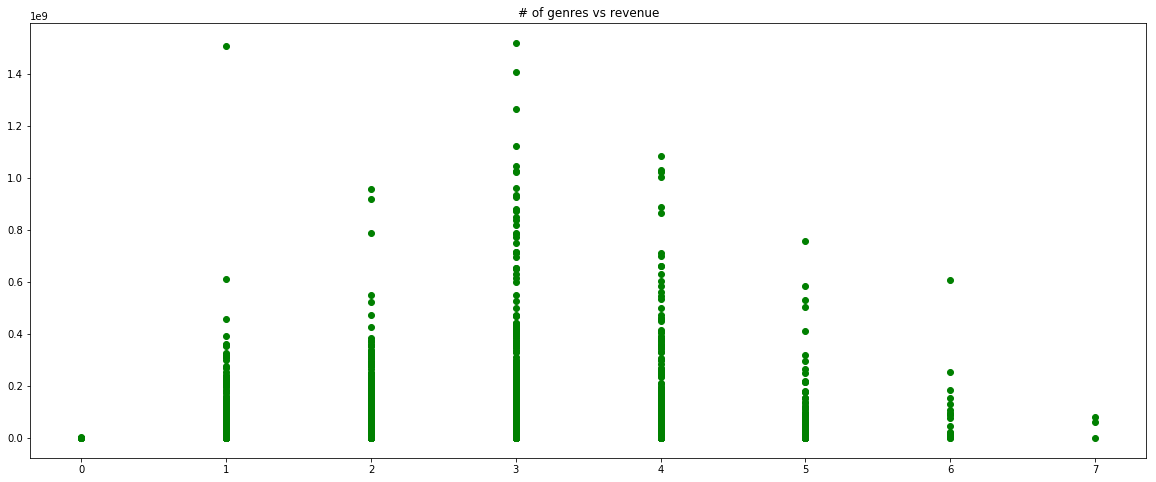

In [9]:
train_set["number_of_genres"] = [len(l) for l in train_set["genres"]]

plt.figure(figsize=(20, 8))
plt.scatter(train_set['number_of_genres'], train_set['revenue'], color="g")
plt.title('# of genres vs revenue')

It appears there is some kind of a second order relation between this new feature and the revenue. No reason to remove it. We will also construct this feature for the test set.

In [10]:
test_set["number_of_genres"] = [len(l) for l in test_set["genres"]]

Finally, we can remove the the "genres" column.

In [11]:
train_set.drop(['genres'], axis=1, inplace=True)
test_set.drop(['genres'], axis=1, inplace=True)
train_set.head(2)

id                              belongs_to_collection    budget homepage  \
0   1  [{u'backdrop_path': u'/noeTVcgpBiD48fDjFVic1Vz...  14000000      NaN   
1   2  [{u'backdrop_path': u'/zSEtYD77pKRJlUPx34BJgUG...  40000000      NaN   

     imdb_id original_language                            original_title  \
0  tt2637294                en                    Hot Tub Time Machine 2   
1  tt0368933                en  The Princess Diaries 2: Royal Engagement   

                                            overview  popularity  \
0  When Lou, who has become the "father of the In...    6.575393   
1  Mia Thermopolis is now a college graduate and ...    8.248895   

                        poster_path  \
0  /tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg   
1  /w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg   

                                production_companies  \
0  [{u'name': u'Paramount Pictures', u'id': 4}, {...   
1     [{u'name': u'Walt Disney Pictures', u'id': 2}]   

                                production_countries release_date  runtime  \
0  [{u'iso_3166_1': u'US', u'name': u'United Stat...      2/20/15     93.0   
1  [{u'iso_3166_1': u'US', u'name': u'United Stat...       8/6/04    113.0   

                               spoken_languages    status  \
0  [{u'iso_639_1': u'en', u'name': u'English'}]  Released   
1  [{u'iso_639_1': u'en', u'name': u'English'}]  Released   

                                             tagline  \
0  The Laws of Space and Time are About to be Vio...   
1  It can take a lifetime to find true love; she'...   

                                      title  \
0                    Hot Tub Time Machine 2   
1  The Princess Diaries 2: Royal Engagement   

                                            Keywords  \
0  [{u'id': 4379, u'name': u'time travel'}, {u'id...   
1  [{u'id': 2505, u'name': u'coronation'}, {u'id'...   

                                                cast  \
0  [{u'name': u'Rob Corddry', u'gender': 2, u'cha...   
1  [{u'name': u'Anne Hathaway', u'gender': 1, u'c...   

                                                crew   revenue  \
0  [{u'name': u'Kelly Cantley', u'gender': 0, u'd...  12314651   
1  [{u'name': u'Garry Marshall', u'gender': 2, u'...  95149435   

   genre_name_Mystery  genre_name_Romance  genre_name_History  \
0                   0                   0                   0   
1                   0                   1                   0   

   genre_name_Family  genre_name_Fantasy  genre_name_Horror  genre_name_Crime  \
0                  0                   0                  0                 0   
1                  1                   0                  0                 0   

   genre_name_Drama  genre_name_Science Fiction  genre_name_Animation  \
0                 0                           0                     0   
1                 1                           0                     0   

   genre_name_Music  genre_name_Adventure  genre_name_Action  \
0                 0                     0                  0   
1                 0                     0                  0   

   genre_name_Comedy  genre_name_War  genre_name_Thriller  number_of_genres  
0                  1               0                    0                 1  
1                  1               0                    0                 4

#### ii. Spoken_languages feature

Much like to the "generes" feature, the values here are also lists of dictionaries, where each dictionary has the language and an abreviation. for example, let's have a look at some data point's value fo this featue:

In [12]:
test_set["spoken_languages"][1]

[{'iso_639_1': 'en', 'name': 'English'}]

We will be dealing with this feature in a very similar way to the way we dealt with "genres" feature.
Let's first look at the popularities of each language

In [13]:
spoken_languages_with_repetions = list(x["name"] for l in train_set["spoken_languages"] for x in l)
for lang in spoken_languages_with_repetions:
    print(lang)

English
English
English
English
हिन्दी
한국어/조선말
English
English
العربية
English
English
English
English
English
English
English
Pусский
English
svenska
Srpski
English
Pусский
English
Deutsch
English
English
Français
Italiano
English
English
English
English
English
Français
Italiano
English
English
English
English
日本語
English
English
Français
Français
English
العربية
English
Français
Deutsch
עִבְרִית
日本語
Português
Latin
English
Français
日本語
普通话
English
普通话
Pусский
English
English
한국어/조선말
Français
English
日本語
Español
English
Français
Español
English
English
Français
English
English
English
Italiano
Español
English
Español
English
English
English
Nederlands
English
Italiano
English
English
English
English
English
Français
English
English
English
Français
English
Français
English
Italiano
English
English
English
Español
English
English
广州话 / 廣州話
普通话
English
English
日本語
English

Español
English
Český
English
English
English
தமிழ்
తెలుగు
English
English
Deutsch
English
Español
English
English

English
Français
العربية
English
Français
Italiano
English
English
Français
Italiano
English
English
Français
English
Español
हिन्दी
English
Español
English
English
English
English
English
Italiano
English
Latin
English
English
Français
Pусский
Español
English
Français
Español
English
English
English
English
English
Magyar
English
English

English
Italiano
English
English
Deutsch
日本語
Italiano
Deutsch
English
日本語
English
English
English
Français
English
Dansk
English
English
English
Português
English
हिन्दी
English
English
English
English
English
Latin
Español
English
English
English
English
Español
English
தமிழ்
English
English
English
English
English
English
العربية
English
日本語
svenska
English
English
English
English
English
English
English
English
עִבְרִית
العربية
Deutsch
English
Español
English
Français
Magyar
English
Italiano
English
English
English
English
English
English
English
한국어/조선말
Latin
English
Español
English
Français
Pусский
English
English
English
العربية
Deutsch
English

Deutsch
हिन्दी
English
हिन्दी
English
English
தமிழ்
English
English
Deutsch
English
Français
Italiano
العربية
English
English
Français
Français
English
English
English
English
Deutsch
English
English
Pусский
English
English
Deutsch
Español
English
English
Español
Pусский
Pусский
English
English
English
English
עִבְרִית

Français
English
English
English
English
English
English
English
English
English
English
English
Deutsch
English
తెలుగు
English
English
Türkçe
English
English
English
Český
English
English
English
English

English
English
العربية
English
Français
Română
English
English
Español
日本語
English
Español
English
English
Tiếng Việt
Français
English
English
English
Deutsch
English
Pусский
Français
English
English
广州话 / 廣州話
普通话
ภาษาไทย
English
Český
English
Srpski
English
English
English
English
English
English
English
English
Pусский
Deutsch
Italiano
English
广州话 / 廣州話
普通话
한국어/조선말
English
Español
English
English
日本語
Pусский
English
English
Français
Italiano
English
English
English

This time, it will be easier to deal with the abreviations since they are all written with english letters.

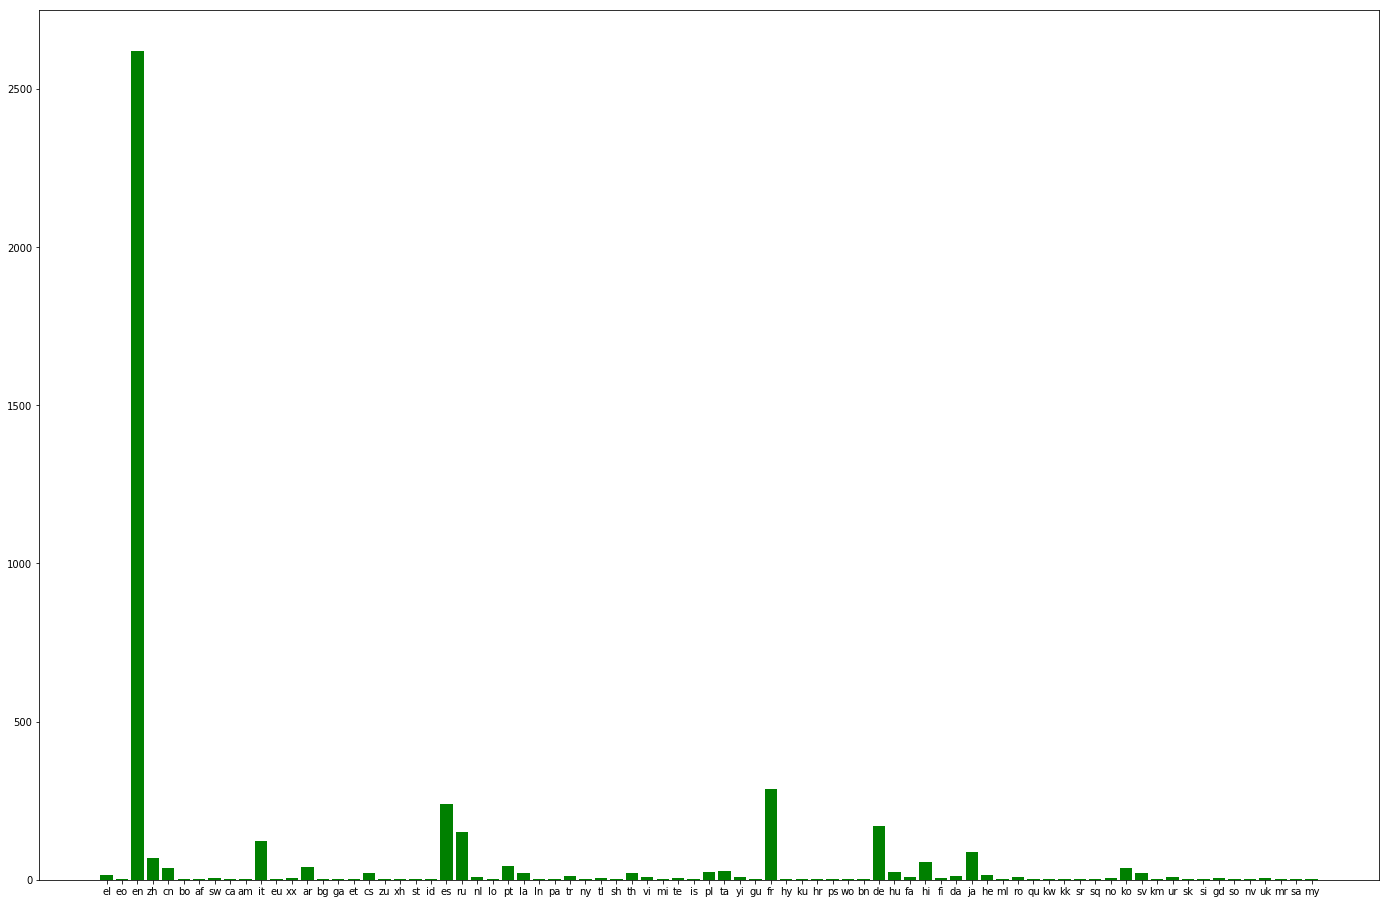

In [14]:
spoken_languages_with_repetions = list(x["iso_639_1"] for l in train_set["spoken_languages"] for x in l)
plt.figure(figsize = (24, 16))

spoken_languages_popularity = {}
for lang in spoken_languages_with_repetions:
    if lang in spoken_languages_popularity.keys():
        continue
    spoken_languages_popularity[lang] = spoken_languages_with_repetions.count(lang)

plt.bar(spoken_languages_popularity.keys(), spoken_languages_popularity.values(), color='g')

plt.show()

From the looks of it English is a much more popular language amongst movies than all other languages, therefore it will be interesting to divide the movies into two sets: English movies and "foreign" movies (meaning movies that don't have english as a spoken language).

Text(0.5,1,'Spoken language (English=1/Foreign=0) vs revenue')

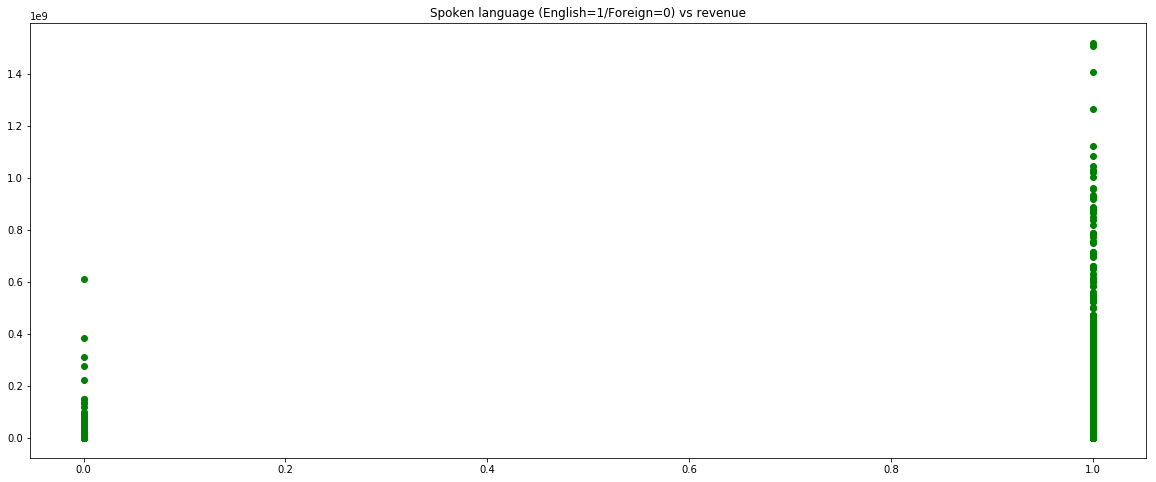

In [15]:
train_set["spoken_english"] = [1 if "English" in str(l) else 0 for l in train_set["spoken_languages"]]
plt.figure(figsize=(20, 8))
plt.scatter(train_set['spoken_english'], train_set['revenue'], color="g")
plt.title('Spoken language (English=1/Foreign=0) vs revenue')

This plot supports our claim, and that is that it is very much interesting whether a movie has English as a spoken language in it or not. It also makes some sense, because English is the universal language which helps a movie get more global attention/popularity and therefore greater revenues.

In [16]:
test_set["spoken_english"] = [1 if "English" in str(l) else 0 for l in test_set["spoken_languages"]]

Another interesting perspective is -just like in the "Generes" feature- the number of spoken languages per each movie. Like we did before, we will check the relevance of the number of spoken languages by plotting it against the revenue.

Text(0.5,1,'# of spoken languages vs revenue')

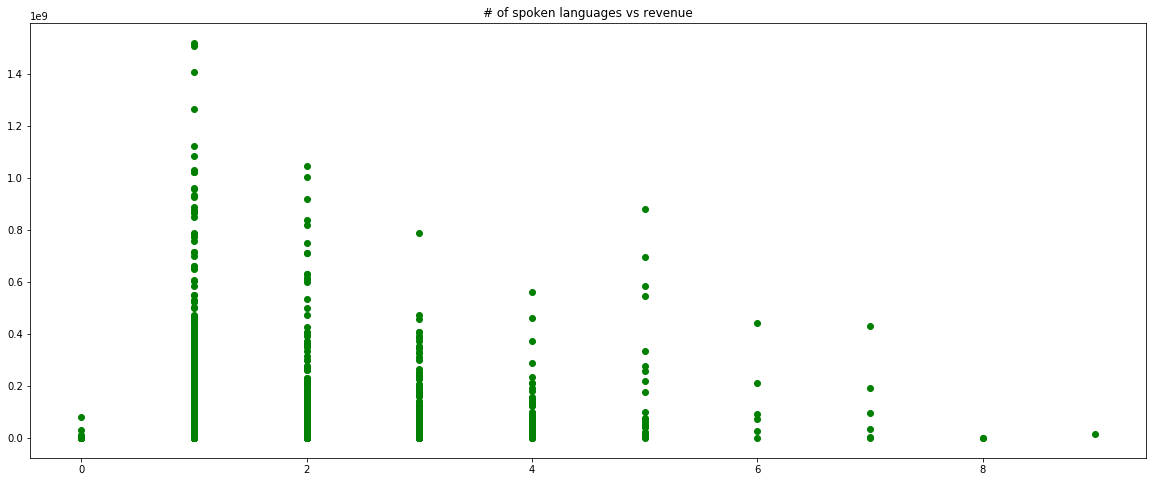

In [17]:
train_set["number_of_spoken_languages"] = [len(l) for l in train_set["spoken_languages"]]

plt.figure(figsize=(20, 8))
plt.scatter(train_set['number_of_spoken_languages'], train_set['revenue'], color="g")
plt.title('# of spoken languages vs revenue')

It is clear that there is some linear correlation between the number of spoken languages in a film and its total revenue (The less spoken languages -excluding the silent movies- the greater the revenue) . We should probably keep this new feature (and add it to the test set of course).

In [18]:
test_set["number_of_spoken_languages"] = [len(l) for l in test_set["spoken_languages"]]

And finally, we can remove the original "spoken_languages" feature.

In [19]:
train_set.drop(['spoken_languages'], axis=1, inplace=True)
test_set.drop(['spoken_languages'], axis=1, inplace=True)
train_set.head(2)

id                              belongs_to_collection    budget homepage  \
0   1  [{u'backdrop_path': u'/noeTVcgpBiD48fDjFVic1Vz...  14000000      NaN   
1   2  [{u'backdrop_path': u'/zSEtYD77pKRJlUPx34BJgUG...  40000000      NaN   

     imdb_id original_language                            original_title  \
0  tt2637294                en                    Hot Tub Time Machine 2   
1  tt0368933                en  The Princess Diaries 2: Royal Engagement   

                                            overview  popularity  \
0  When Lou, who has become the "father of the In...    6.575393   
1  Mia Thermopolis is now a college graduate and ...    8.248895   

                        poster_path  \
0  /tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg   
1  /w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg   

                                production_companies  \
0  [{u'name': u'Paramount Pictures', u'id': 4}, {...   
1     [{u'name': u'Walt Disney Pictures', u'id': 2}]   

                                production_countries release_date  runtime  \
0  [{u'iso_3166_1': u'US', u'name': u'United Stat...      2/20/15     93.0   
1  [{u'iso_3166_1': u'US', u'name': u'United Stat...       8/6/04    113.0   

     status                                            tagline  \
0  Released  The Laws of Space and Time are About to be Vio...   
1  Released  It can take a lifetime to find true love; she'...   

                                      title  \
0                    Hot Tub Time Machine 2   
1  The Princess Diaries 2: Royal Engagement   

                                            Keywords  \
0  [{u'id': 4379, u'name': u'time travel'}, {u'id...   
1  [{u'id': 2505, u'name': u'coronation'}, {u'id'...   

                                                cast  \
0  [{u'name': u'Rob Corddry', u'gender': 2, u'cha...   
1  [{u'name': u'Anne Hathaway', u'gender': 1, u'c...   

                                                crew   revenue  \
0  [{u'name': u'Kelly Cantley', u'gender': 0, u'd...  12314651   
1  [{u'name': u'Garry Marshall', u'gender': 2, u'...  95149435   

   genre_name_Mystery  genre_name_Romance  genre_name_History  \
0                   0                   0                   0   
1                   0                   1                   0   

   genre_name_Family  genre_name_Fantasy  genre_name_Horror  genre_name_Crime  \
0                  0                   0                  0                 0   
1                  1                   0                  0                 0   

   genre_name_Drama  genre_name_Science Fiction  genre_name_Animation  \
0                 0                           0                     0   
1                 1                           0                     0   

   genre_name_Music  genre_name_Adventure  genre_name_Action  \
0                 0                     0                  0   
1                 0                     0                  0   

   genre_name_Comedy  genre_name_War  genre_name_Thriller  number_of_genres  \
0                  1               0                    0                 1   
1                  1               0                    0                 4   

   spoken_english  number_of_spoken_languages  
0               1                           1  
1               1                           1

#### iii.	belongs_to_collection feature:

First thing we want to check here is whether for a specified movie, the fact of belonging to some collection would affect the revenue.

In [20]:
train_set['belongs_to_collection'][0]

[{'backdrop_path': '/noeTVcgpBiD48fDjFVic1Vz7ope.jpg',
  'id': 313576,
  'name': 'Hot Tub Time Machine Collection',
  'poster_path': '/iEhb00TGPucF0b4joM1ieyY026U.jpg'}]

We believe that only the name (or the id) would be relevant, So let us extract the (what we believe is) equivelant feature "collection_name"

In [21]:
train_set['collection_name'] = train_set['belongs_to_collection'].apply(lambda x: x[0]['name'] if x != {} else 0)

test_set['collection_name'] = test_set['belongs_to_collection'].apply(lambda x: x[0]['name'] if x != {} else 0)

Let us seperate the data into movies that do belong to some collection and movies that don't.

Text(0.5,1,'has/ does not have collection vs revenue')

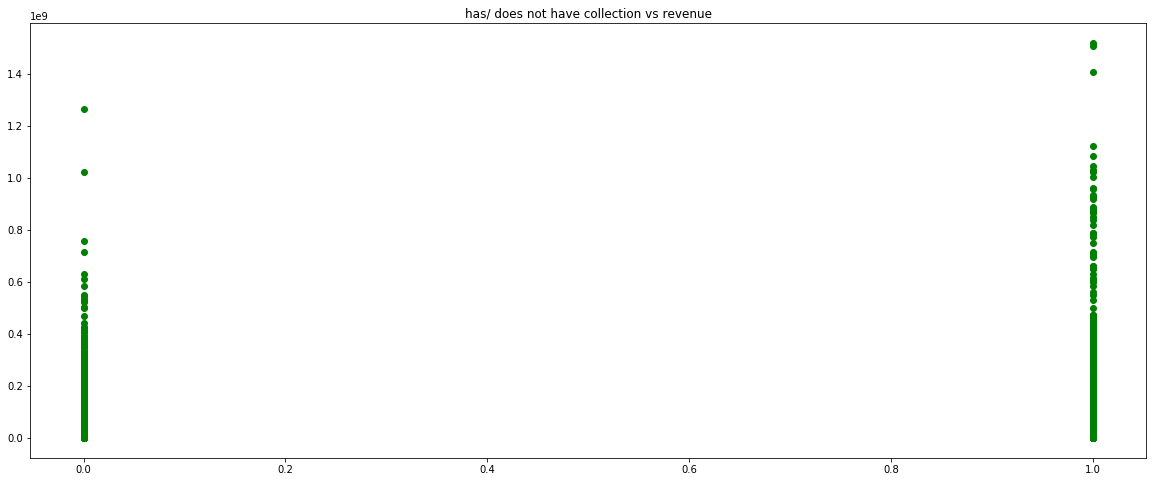

In [22]:
train_set['has_collection'] = train_set['belongs_to_collection'].apply(lambda x: len(x) if x != {} else 0)
plt.figure(figsize=(20, 8))
plt.scatter(train_set['has_collection'], train_set['revenue'], color="g")
plt.title('has/ does not have collection vs revenue')


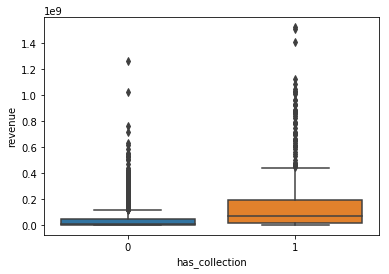

In [23]:
import seaborn as sns
sns.boxplot(x='has_collection', y='revenue', data=train_set)



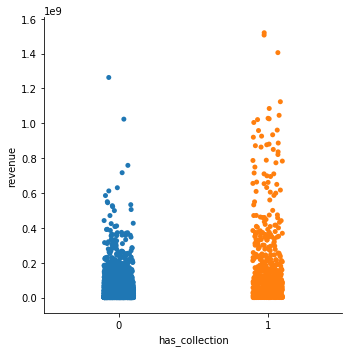

In [24]:
sns.catplot(x='has_collection', y='revenue', data=train_set)



Depending on this box plot, it seems there is some effect of having a collection on the revenue. We can clearly see that the mean revenue for movies belonging to some collection is greater than that of those not belonging to any collection. let's apply the same transformation on the test set:

In [25]:
test_set['has_collection'] = test_set['belongs_to_collection'].apply(lambda x: len(x) if x != {} else 0)


And as usual, we will remove the original feature.

In [26]:
train_set.drop(['belongs_to_collection'], axis=1, inplace=True)
test_set.drop(['belongs_to_collection'], axis=1, inplace=True)
train_set.head(2)

id    budget homepage    imdb_id original_language  \
0   1  14000000      NaN  tt2637294                en   
1   2  40000000      NaN  tt0368933                en   

                             original_title  \
0                    Hot Tub Time Machine 2   
1  The Princess Diaries 2: Royal Engagement   

                                            overview  popularity  \
0  When Lou, who has become the "father of the In...    6.575393   
1  Mia Thermopolis is now a college graduate and ...    8.248895   

                        poster_path  \
0  /tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg   
1  /w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg   

                                production_companies  \
0  [{u'name': u'Paramount Pictures', u'id': 4}, {...   
1     [{u'name': u'Walt Disney Pictures', u'id': 2}]   

                                production_countries release_date  runtime  \
0  [{u'iso_3166_1': u'US', u'name': u'United Stat...      2/20/15     93.0   
1  [{u'iso_3166_1': u'US', u'name': u'United Stat...       8/6/04    113.0   

     status                                            tagline  \
0  Released  The Laws of Space and Time are About to be Vio...   
1  Released  It can take a lifetime to find true love; she'...   

                                      title  \
0                    Hot Tub Time Machine 2   
1  The Princess Diaries 2: Royal Engagement   

                                            Keywords  \
0  [{u'id': 4379, u'name': u'time travel'}, {u'id...   
1  [{u'id': 2505, u'name': u'coronation'}, {u'id'...   

                                                cast  \
0  [{u'name': u'Rob Corddry', u'gender': 2, u'cha...   
1  [{u'name': u'Anne Hathaway', u'gender': 1, u'c...   

                                                crew   revenue  \
0  [{u'name': u'Kelly Cantley', u'gender': 0, u'd...  12314651   
1  [{u'name': u'Garry Marshall', u'gender': 2, u'...  95149435   

   genre_name_Mystery  genre_name_Romance  genre_name_History  \
0                   0                   0                   0   
1                   0                   1                   0   

   genre_name_Family  genre_name_Fantasy  genre_name_Horror  genre_name_Crime  \
0                  0                   0                  0                 0   
1                  1                   0                  0                 0   

   genre_name_Drama  genre_name_Science Fiction  genre_name_Animation  \
0                 0                           0                     0   
1                 1                           0                     0   

   genre_name_Music  genre_name_Adventure  genre_name_Action  \
0                 0                     0                  0   
1                 0                     0                  0   

   genre_name_Comedy  genre_name_War  genre_name_Thriller  number_of_genres  \
0                  1               0                    0                 1   
1                  1               0                    0                 4   

   spoken_english  number_of_spoken_languages  \
0               1                           1   
1               1                           1   

                   collection_name  has_collection  
0  Hot Tub Time Machine Collection               1  
1  The Princess Diaries Collection               1

#### iv. budget feature:
This should be very straight forward, we expect that the higher the budget, the higher the revenues, let's verify this claim


In [27]:
test_set["budget"]

0               0
1           88000
2               0
3         6800000
4         2000000
5               0
6               0
7        30000000
8        16500000
9        90000000
10        2000000
11              0
12        5000000
13         800000
14       20000000
15              0
16       36000000
17      100000000
18              0
19      200000000
20       30000000
21       20000000
22              0
23       27000000
24              0
25       35000000
26        5000000
27       44000000
28         500000
29       35000000
          ...    
4368     25000000
4369     30000000
4370            0
4371     55000000
4372    170000000
4373      1800000
4374     16000000
4375            0
4376      4000000
4377     13200000
4378     42000000
4379            0
4380            0
4381       600000
4382       800000
4383     10000000
4384     15000000
4385     12000000
4386            0
4387            0
4388      1000000
4389            0
4390            0
4391     10000000
4392    15

Text(0.5,1,'budget vs revenue')

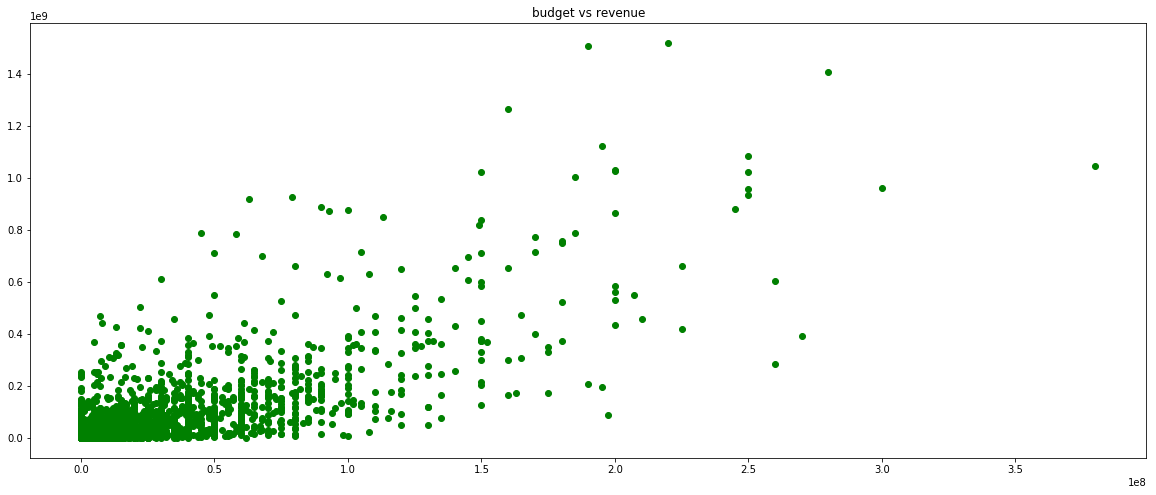

In [28]:
plt.figure(figsize=(20, 8))
plt.scatter(train_set['budget'], train_set['revenue'], color="g")
plt.title('budget vs revenue')

Let's try and bring these numbers down, maybe it'll prove to be more useful...

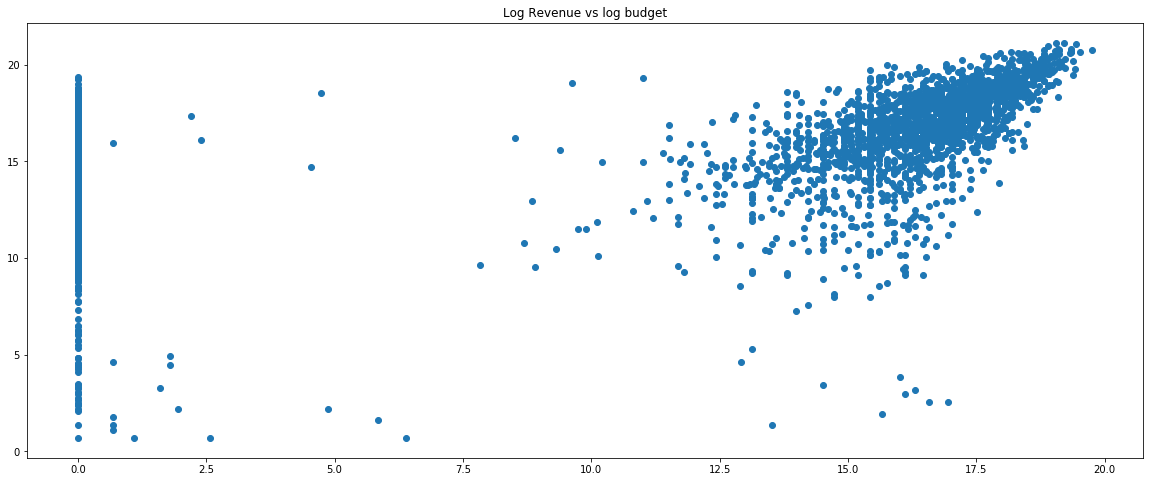

In [29]:
plt.figure(figsize=(20, 8))
plt.scatter(np.log1p(train_set['budget']), np.log1p(train_set['revenue']))
plt.title('Log Revenue vs log budget');

This does look a little more convincing than the previous plot. let's add those features (log of budget and log of revenue)

In [30]:
train_set['log_budget'] = np.log1p(train_set['budget'])
test_set['log_budget'] = np.log1p(test_set['budget'])

In [31]:
train_set["log_revenue"] = np.log1p(train_set['revenue'])

#### v. Keywords feature:

In [32]:
train_set["Keywords"]

0       [{u'id': 4379, u'name': u'time travel'}, {u'id...
1       [{u'id': 2505, u'name': u'coronation'}, {u'id'...
2       [{u'id': 1416, u'name': u'jazz'}, {u'id': 1523...
3       [{u'id': 10092, u'name': u'mystery'}, {u'id': ...
4                                                      {}
5                                                      {}
6                                                      {}
7       [{u'id': 917, u'name': u'journalism'}, {u'id':...
8       [{u'id': 2041, u'name': u'island'}, {u'id': 44...
9       [{u'id': 11800, u'name': u'mockumentary'}, {u'...
10      [{u'id': 240, u'name': u'underdog'}, {u'id': 2...
11      [{u'id': 5801, u'name': u'nerd'}, {u'id': 6876...
12      [{u'id': 255, u'name': u'male nudity'}, {u'id'...
13      [{u'id': 3605, u'name': u'baseball bat'}, {u'i...
14      [{u'id': 476, u'name': u'self-fulfilling proph...
15      [{u'id': 379, u'name': u'skinhead'}, {u'id': 7...
16      [{u'id': 1562, u'name': u'hostage'}, {u'id': 2...
17      [{u'id

We will deal with the Keywords in a similar way we dealt with the Generes feature (afterall, they should have a very similar effect on the target);
Transform only the most popular ones into dummy features, and checxk if there is some relation between the number of keywords for a film to its revenues.

In [33]:
keywords_with_repetions = list(x["name"] for l in train_set["Keywords"] for x in l)
print(len(keywords_with_repetions))

21680


We certainly don't want all 21680 keywords, let's have a look at their popularity and decide which keywords we do want in our data

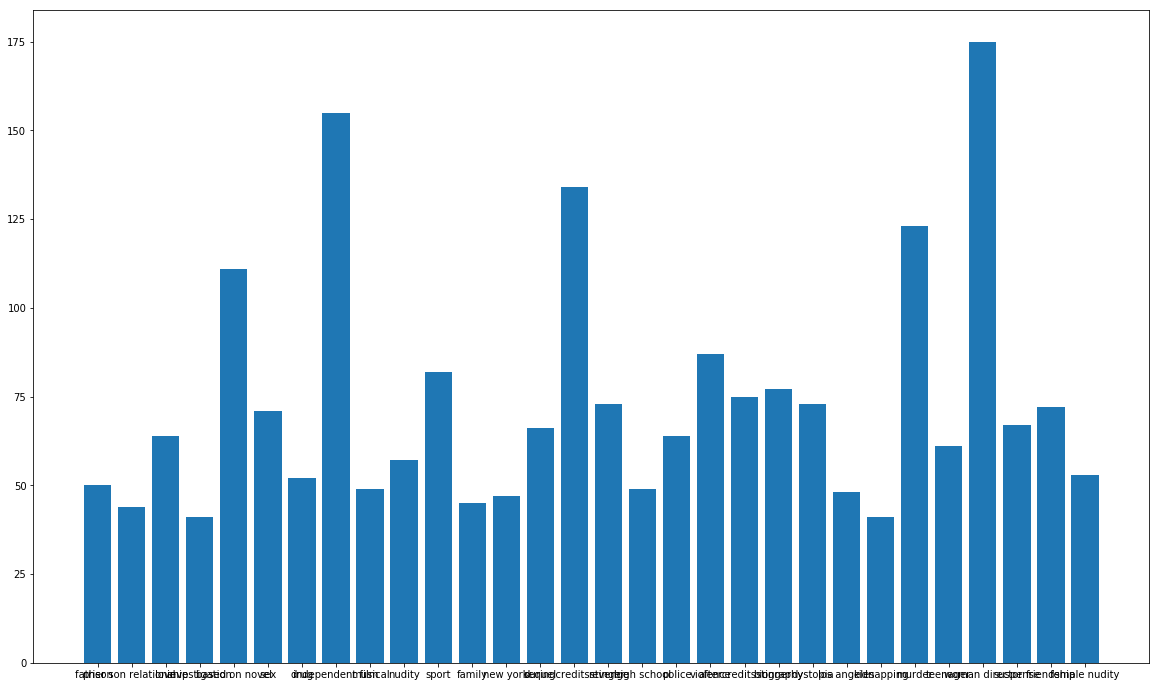

In [34]:
from collections import Counter
# decoding and encoding in order to ignore non ascii names
keywords_popularity = Counter([kw.decode("utf-8","ignore").encode("ascii", "ignore") for kw in keywords_with_repetions])
popular_kw = [(x, keywords_popularity[x]) for x in keywords_popularity if keywords_popularity[x] > 40 ]
unpopular_kw = [(x, keywords_popularity[x]) for x in keywords_popularity if keywords_popularity[x] < 10 ]


plt.figure(figsize=(20, 12))
plt.bar([k[0] for k in popular_kw], [k[1] for k in popular_kw])
plt.show()




In [35]:
#let's just check how many unpopular keywords there are, only for comparison purpuses
print("number of unpopular keywords: {}".format(len(unpopular_kw)))

number of unpopular keywords: 7040


We'll create new dummy feature for all the popular keywords.
We could see from the graphs above that there are much less keywords with 40 - 175 appearances than there are keywords with less than 10 appearences. This tells us that there are few keywords that are very popular (and therefore might be important for classification) and many (many) features that are not popular at all, which can result in overfitting.

In [36]:
def convert_keywords_feature_to_dummy_features(df):
    for kw in popular_kw:
        df["kw_"+kw[0]] = [1 if kw[0] in str(l) else 0
                                           for l in df["Keywords"]]
        
convert_keywords_feature_to_dummy_features(train_set)
convert_keywords_feature_to_dummy_features(test_set)
train_set.head(2)
train_set.drop(['Keywords'], axis=1, inplace=True)
test_set.drop(['Keywords'], axis=1, inplace=True)

### Cast Feature:
let's first have a look at what info is presented in the values of this feature

In [37]:
train_set["cast"][0]

[{'cast_id': 4,
  'character': 'Lou',
  'credit_id': '52fe4ee7c3a36847f82afae7',
  'gender': 2,
  'id': 52997,
  'name': 'Rob Corddry',
  'order': 0,
  'profile_path': '/k2zJL0V1nEZuFT08xUdOd3ucfXz.jpg'},
 {'cast_id': 5,
  'character': 'Nick',
  'credit_id': '52fe4ee7c3a36847f82afaeb',
  'gender': 2,
  'id': 64342,
  'name': 'Craig Robinson',
  'order': 1,
  'profile_path': '/tVaRMkJXOEVhYxtnnFuhqW0Rjzz.jpg'},
 {'cast_id': 6,
  'character': 'Jacob',
  'credit_id': '52fe4ee7c3a36847f82afaef',
  'gender': 2,
  'id': 54729,
  'name': 'Clark Duke',
  'order': 2,
  'profile_path': '/oNzK0umwm5Wn0wyEbOy6TVJCSBn.jpg'},
 {'cast_id': 7,
  'character': 'Adam Jr.',
  'credit_id': '52fe4ee7c3a36847f82afaf3',
  'gender': 2,
  'id': 36801,
  'name': 'Adam Scott',
  'order': 3,
  'profile_path': '/5gb65xz8bzd42yjMAl4zwo4cvKw.jpg'},
 {'cast_id': 8,
  'character': 'Hot Tub Repairman',
  'credit_id': '52fe4ee7c3a36847f82afaf7',
  'gender': 2,
  'id': 54812,
  'name': 'Chevy Chase',
  'order': 4,
  'prof

We believe the possibly useful aspects are, like before, the number of cast members per film, weather or not a popular cast member is in the film, whether or not a popular charachter is in the film, the number of male cast members and the number of female cast members. (males are gender 2 and females are gender 1, 0 is unspecified according to here: https://www.themoviedb.org/talk/59bf8557c3a3682ff80105d0?language=en-US).


In [38]:
list_of_cast_names = list(train_set['cast'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
Counter([i for j in list_of_cast_names for i in j]).most_common(15)

[('Robert De Niro', 30),
 ('Samuel L. Jackson', 30),
 ('Morgan Freeman', 27),
 ('Susan Sarandon', 25),
 ('Bruce Willis', 25),
 ('J.K. Simmons', 25),
 ('Liam Neeson', 25),
 ('John Turturro', 24),
 ('Bruce McGill', 24),
 ('Willem Dafoe', 23),
 ('Forest Whitaker', 23),
 ('Nicolas Cage', 22),
 ('Bill Murray', 22),
 ('Owen Wilson', 22),
 ('Jason Statham', 21)]

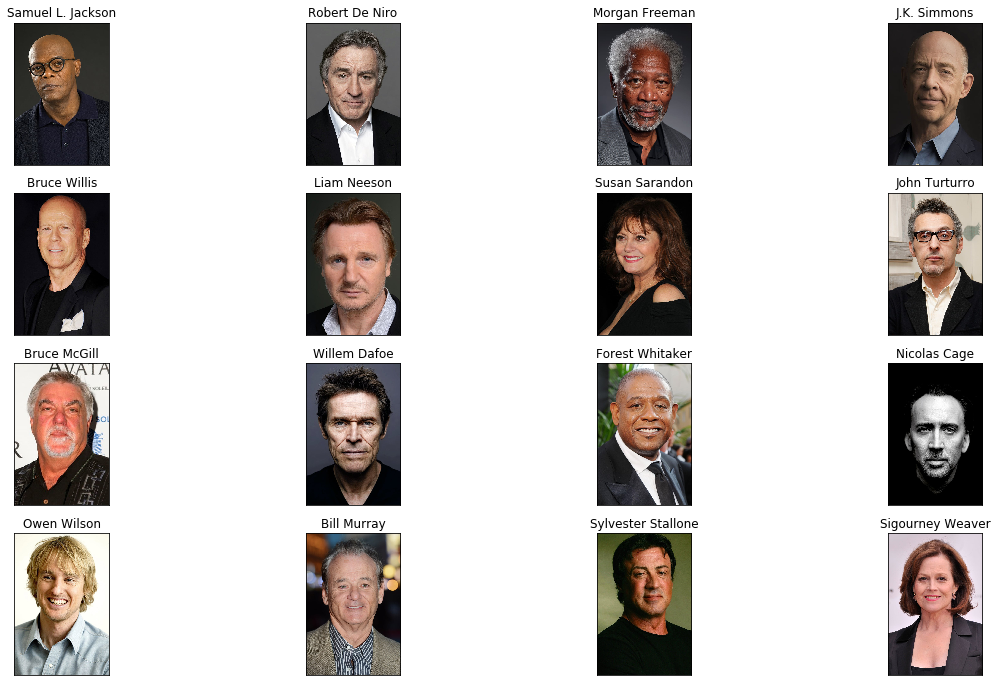

In [39]:
from PIL import Image
from urllib import urlopen


list_of_cast_names_url = list(train_set['cast'].apply(lambda x: [(i['name'], i['profile_path']) for i in x] if x != {} else []).values)
d = Counter([i for j in list_of_cast_names_url for i in j]).most_common(16)
fig = plt.figure(figsize=(20, 12))
for i, p in enumerate([j[0] for j in d]):
    ax = fig.add_subplot(4, 4, i+1, xticks=[], yticks=[])
    im = Image.open(urlopen("https://image.tmdb.org/t/p/w600_and_h900_bestv2{}".format(p[1])))
    plt.imshow(im)
    ax.set_title('{}'.format(p[0]))

We believe thathaving a popular actor in a film has an effect on its revenue, let's count then, for each film, how many actors take part in it.

In [40]:
popular_actors = [a[0][0] for a in d]
train_set["has_popular_actor"] = list(train_set["cast"].apply(lambda x: int(sum([int(i["name"] in popular_actors) for i in x] if x != {} else []) > 0)))

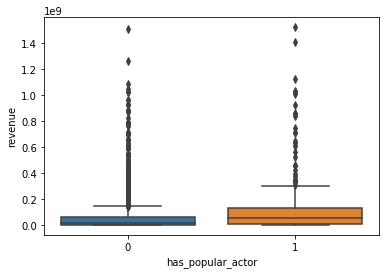

In [41]:
sns.boxplot(x='has_popular_actor', y='revenue', data=train_set)


Our hypothesis regarding having a popular actor in a film is quite clear from this box plot.
before adding the same feature to the test set, let's check if specific actors have more/less influence than others.


In [42]:
from statistics import median, mean
import operator
medians = {}
means = {}
for g in popular_actors:
    f = 'cast_name_' + g
    train_set[f] = train_set["cast"].apply(lambda x: 1 if g in str(x) else 0)
    medians[g] = median(list(train_set.loc[train_set[f] > 0]["revenue"]))
    means[g] = mean(list(train_set.loc[train_set[f] > 0]["revenue"]))
medians["no_famous_actor"] = median(list(train_set.loc[train_set["has_popular_actor"] == 0]["revenue"]))
means["no_famous_actor"] = mean(list(train_set.loc[train_set["has_popular_actor"] == 0]["revenue"]))


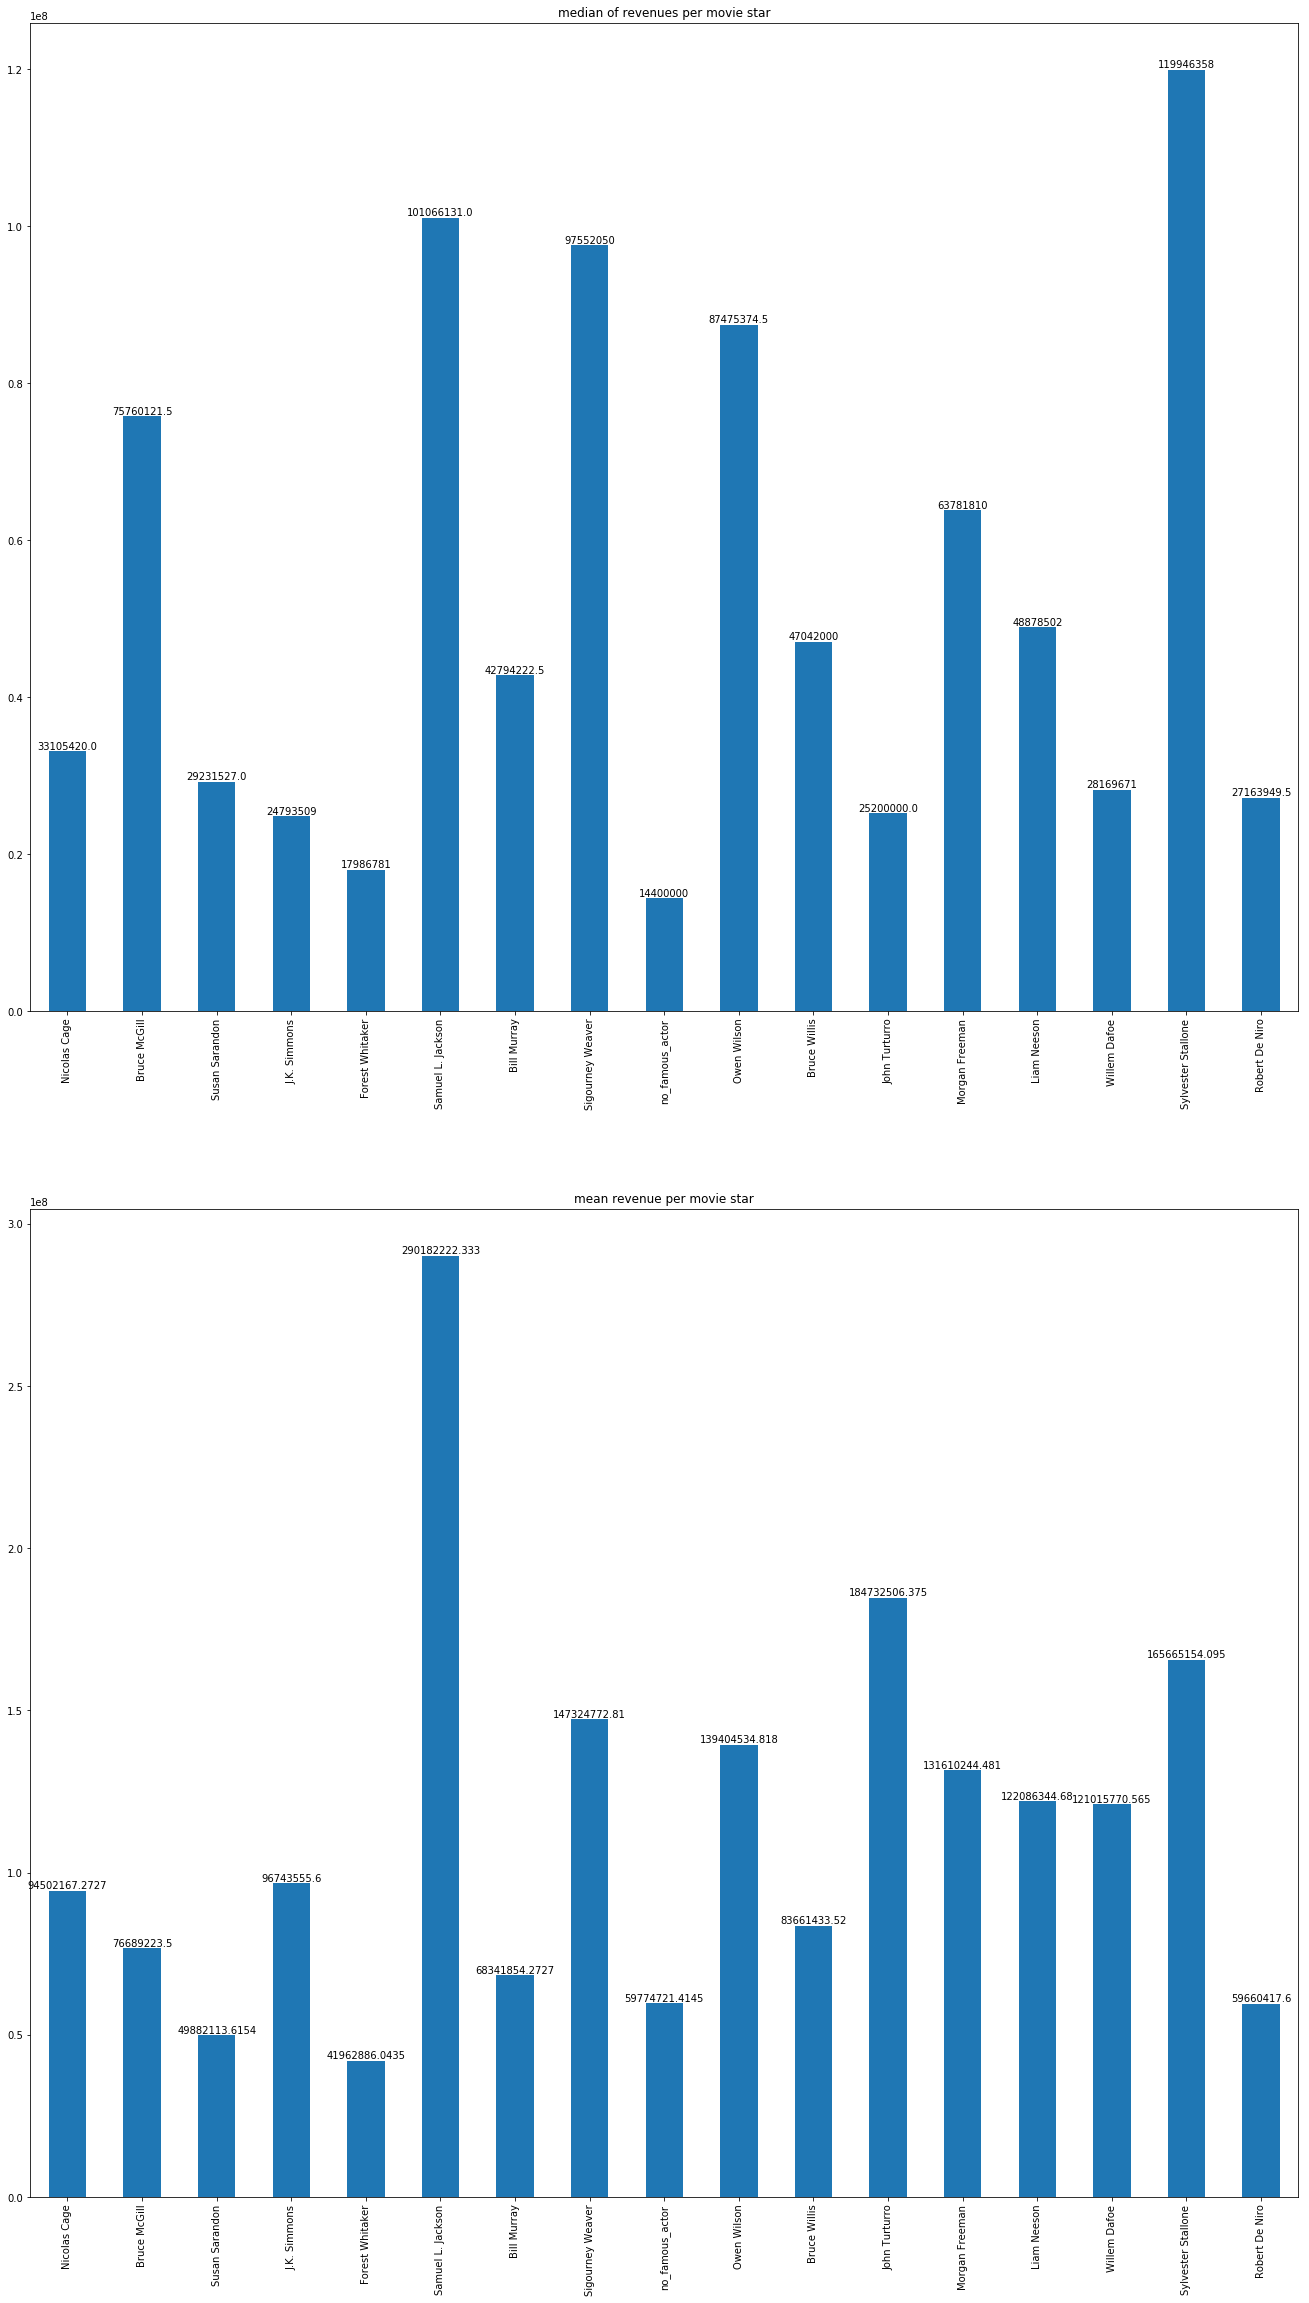

In [43]:
def bar_plot(l):
    x_labels = l.keys()
    y_labels = l.values()
    ax = pd.Series(y_labels).plot(kind='bar')
    ax.set_xticklabels(x_labels)

    rects = ax.patches

    for rect, label in zip(rects, y_labels):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')
plt.figure(figsize=(50, 40))
plt.subplot(2, 2, 1)
plt.title('median of revenues per movie star')
bar_plot(medians)
plt.subplot(2,2,3)
plt.title('mean revenue per movie star')
bar_plot(means)

We can se that not only does having a famous actor affect the revenue of the film, but also which actor. It is unfair to declare that movies with Samuel L. Jackson make the same revenue as movies with Forest Whitaker or Nicolas Cage. Let's add then a feature for each of these stars.

In [44]:
for g in popular_actors:
    f = 'cast_name_' + g
    test_set[f] = test_set["cast"].apply(lambda x: 1 if g in str(x) else 0)
train_set.drop(['has_popular_actor'], axis=1, inplace=True)


Moving on to do the same thing for the characters in the films:

In [45]:
list_of_cast_chars = list(train_set['cast'].apply(lambda x: [i['character'] for i in x] if x != {} else []).values)
Counter([i for j in list_of_cast_chars for i in j]).most_common(15)

[('', 818),
 ('Himself', 610),
 ('Herself', 155),
 ('Dancer', 144),
 ('Additional Voices (voice)', 100),
 ('Doctor', 77),
 ('Reporter', 70),
 ('Waitress', 69),
 ('Nurse', 65),
 ('Bartender', 55),
 ('Debutante', 54),
 ('Jack', 54),
 ('Security Guard', 50),
 ('Paul', 48),
 ('Frank', 44)]

It is somewhat amusing that the mot two popular characters are "Himself" and "Herself", where the male version is about 4X more popular.

In [46]:
popular_chars = [m[0] for m in Counter([i for j in list_of_cast_chars for i in j]).most_common(15)]
for g in popular_chars:
    if g == '':
        continue
    train_set['cast_character_' + g] = train_set['cast'].apply(lambda x: 1 if g in str(x) else 0)
    test_set['cast_character_' + g] = test_set['cast'].apply(lambda x: 1 if g in str(x) else 0)

and finaly, the number of cast members in the film, and maybe the percentage of males/females.


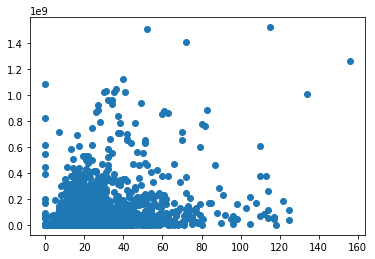

In [47]:
train_set['total_cast_members'] = train_set['cast'].apply(lambda x: len(x) if x != {} else 0)
plt.scatter(train_set['total_cast_members'], train_set['revenue'])

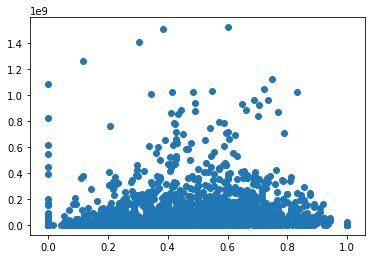

In [48]:
train_set["cast_male_percentage"] = train_set['cast'].apply(lambda x: 0 if len(x)==0 else float(len([i for i in x if i["gender"] == 2]))/len(x))
plt.scatter(train_set['cast_male_percentage'], train_set['revenue'])

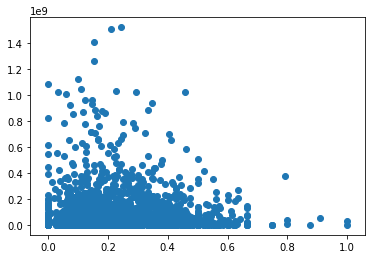

In [49]:
train_set["cast_female_percentage"] = train_set['cast'].apply(lambda x: 0 if len(x)==0 else float(len([i for i in x if i["gender"] == 1]))/len(x))
plt.scatter(train_set['cast_female_percentage'], train_set['revenue'])

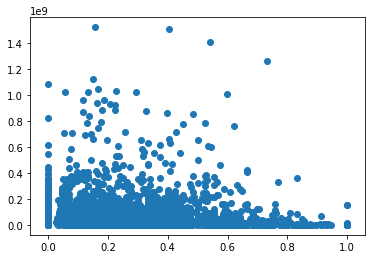

In [50]:
train_set["cast_unspecified_percentage"] = train_set['cast'].apply(lambda x: 0 if len(x)==0 else float(len([i for i in x if i["gender"] == 0]))/len(x))
plt.scatter(train_set['cast_unspecified_percentage'], train_set['revenue'])

There's quite a big difference between the graph describing the female actors percentage vs revenue and the one describing male percentage vs revenue. Gender equality does not apply in the movie industry at all...
Let's add these features to the test set, and remove the old "cast" feature.

In [51]:
test_set['total_cast_members'] = test_set['cast'].apply(lambda x: len(x) if x != {} else 0)
test_set["cast_male_percentage"] = test_set['cast'].apply(lambda x: 0 if len(x)==0 else float(len([i for i in x if i["gender"] == 2]))/len(x))
test_set["cast_female_percentage"] = test_set['cast'].apply(lambda x: 0 if len(x)==0 else float(len([i for i in x if i["gender"] == 1]))/len(x))
test_set["cast_unspecified_percentage"] = test_set['cast'].apply(lambda x: 0 if len(x)==0 else float(len([i for i in x if i["gender"] == 0]))/len(x))

train_set.drop(['cast'], axis=1, inplace=True)
test_set.drop(['cast'], axis=1, inplace=True)
train_set

id     budget                                           homepage  \
0        1   14000000                                                NaN   
1        2   40000000                                                NaN   
2        3    3300000                  http://sonyclassics.com/whiplash/   
3        4    1200000                         http://kahaanithefilm.com/   
4        5          0                                                NaN   
5        6    8000000                                                NaN   
6        7   14000000                 http://www.thepossessionmovie.com/   
7        8          0                                                NaN   
8        9          0                                                NaN   
9       10    6000000                                                NaN   
10      11    1000000                                                NaN   
11      12          0                                                NaN   
12      13   15000000                      http://www.dreamworks.com/ab/   
13      14   53000000                                                NaN   
14      15  102000000                                                NaN   
15      16     500000              http://skinningmovie.com/synopsis.htm   
16      17   26000000                                                NaN   
17      18          0                                                NaN   
18      19    8000000                                                NaN   
19      20   32000000                                                NaN   
20      21   80000000                                                NaN   
21      22    4000000                                                NaN   
22      23          0                http://www.magnetreleasing.com/vhs/   
23      24          0                        http://insightthemovie.com/   
24      25          0                http://www.blacksheep-themovie.com/   
25      26          0                                                NaN   
26      27   10000000                                                NaN   
27      28   11000000                                                NaN   
28      29    6000000                                                NaN   
29      30   45000000                                                NaN   
...    ...        ...                                                ...   
2970  2971   25000000                                                NaN   
2971  2972   20000000                                                NaN   
2972  2973          0                                                NaN   
2973  2974          0                                                NaN   
2974  2975   20000000                                                NaN   
2975  2976   45000000              http://www.aliensintheatticmovie.com/   
2976  2977   16000000                                                NaN   
2977  2978   53000000  http://angeleyesmovie.warnerbros.com/index_nof...   
2978  2979          0                                                NaN   
2979  2980   35000000                     http://www.theback-upplan.com/   
2980  2981     300000           https://www.facebook.com/Actionherobiju/   
2981  2982          0                                                NaN   
2982  2983     500000                                                NaN   
2983  2984   35000000                                                NaN   
2984  2985   80000000        http://www.sonypictures.com/homevideo/swat/   
2985  2986   37665000  http://www.sonypictures.com/homevideo/freedoml...   
2986  2987   20000000                                                NaN   
2987  2988          0                                                NaN   
2988  2989          0                                                NaN   
2989  2990          0                                                NaN   
2990  2991          0                                   

### Crew Feature:
Let's check what useful info we can get from this feature:


In [52]:
train_set["crew"][0]

[{'credit_id': '59ac067c92514107af02c8c8',
  'department': 'Directing',
  'gender': 0,
  'id': 1449071,
  'job': 'First Assistant Director',
  'name': 'Kelly Cantley',
  'profile_path': None},
 {'credit_id': '52fe4ee7c3a36847f82afad7',
  'department': 'Directing',
  'gender': 2,
  'id': 3227,
  'job': 'Director',
  'name': 'Steve Pink',
  'profile_path': '/myHOgo8mQSCiCAZNGMRdHVr03jr.jpg'},
 {'credit_id': '5524ed25c3a3687ded000d88',
  'department': 'Writing',
  'gender': 2,
  'id': 347335,
  'job': 'Writer',
  'name': 'Josh Heald',
  'profile_path': '/pwXJIenrDMrG7t3zNfLvr8w1RGU.jpg'},
 {'credit_id': '5524ed2d925141720c001128',
  'department': 'Writing',
  'gender': 2,
  'id': 347335,
  'job': 'Characters',
  'name': 'Josh Heald',
  'profile_path': '/pwXJIenrDMrG7t3zNfLvr8w1RGU.jpg'},
 {'credit_id': '5524ed3d92514166c1004a5d',
  'department': 'Production',
  'gender': 2,
  'id': 57822,
  'job': 'Producer',
  'name': 'Andrew Panay',
  'profile_path': None},
 {'credit_id': '5524ed4bc3a36

We have a name, a job title, gender and department for every crew member.
Let's start with names, as usual, we will look at the most popular.

In [53]:
crew_names = list(train_set["crew"].apply(lambda x: [i["name"] for i in x] if x!= {} else []))
Counter([i for j in crew_names for i in j]).most_common(15)

[('Avy Kaufman', 50),
 ('Robert Rodriguez', 44),
 ('Deborah Aquila', 40),
 ('James Newton Howard', 39),
 ('Mary Vernieu', 38),
 ('Luc Besson', 37),
 ('Jerry Goldsmith', 37),
 ('Steven Spielberg', 37),
 ('Francine Maisler', 35),
 ('Tricia Wood', 35),
 ('James Horner', 33),
 ('Kerry Barden', 32),
 ('Janet Hirshenson', 30),
 ('Harvey Weinstein', 30),
 ('Bob Weinstein', 30)]

We believe that the name of some crew member should be tied to their job title, it makes sense that a director wouldn't help much as a composer, and vice versa. We can test this theorem:

In [54]:
crew_names_jobs = list(train_set["crew"].apply(lambda x: [i["name"]+"_"+i["job"] for i in x] if x!= {} else []))
Counter([i for j in crew_names_jobs for i in j]).most_common(15)

[('Avy Kaufman_Casting', 50),
 ('Deborah Aquila_Casting', 40),
 ('James Newton Howard_Original Music Composer', 38),
 ('Jerry Goldsmith_Original Music Composer', 37),
 ('Mary Vernieu_Casting', 37),
 ('Tricia Wood_Casting', 35),
 ('Francine Maisler_Casting', 35),
 ('James Horner_Original Music Composer', 33),
 ('Kerry Barden_Casting', 32),
 ('Janet Hirshenson_Casting', 30),
 ('Jane Jenkins_Casting', 29),
 ('John Papsidera_Casting', 28),
 ('Billy Hopkins_Casting', 27),
 ('Bob Weinstein_Executive Producer', 27),
 ('Mindy Marin_Casting', 26)]

We already see that the list of most popular names has changed.

In [55]:
popular_crew_names = [a[0] for a in Counter([i for j in crew_names for i in j]).most_common(15)]
for name in popular_crew_names:
    train_set["crew_name_"+name] = train_set["crew"].apply(lambda x: 1 if name in str(x) else 0)
    
popular_crew_names_jobs = [a[0].split("_") for a in Counter([i for j in crew_names_jobs for i in j]).most_common(15)]
for (name, job) in popular_crew_names_jobs:
    train_set["crew_name_"+name+"_job_"+job] = train_set["crew"].apply(lambda x: 1 if len([i for i in x if i["name"]==name and i["job"]==job])>0 else 0)


In [56]:
train_set

id     budget                                           homepage  \
0        1   14000000                                                NaN   
1        2   40000000                                                NaN   
2        3    3300000                  http://sonyclassics.com/whiplash/   
3        4    1200000                         http://kahaanithefilm.com/   
4        5          0                                                NaN   
5        6    8000000                                                NaN   
6        7   14000000                 http://www.thepossessionmovie.com/   
7        8          0                                                NaN   
8        9          0                                                NaN   
9       10    6000000                                                NaN   
10      11    1000000                                                NaN   
11      12          0                                                NaN   
12      13   15000000                      http://www.dreamworks.com/ab/   
13      14   53000000                                                NaN   
14      15  102000000                                                NaN   
15      16     500000              http://skinningmovie.com/synopsis.htm   
16      17   26000000                                                NaN   
17      18          0                                                NaN   
18      19    8000000                                                NaN   
19      20   32000000                                                NaN   
20      21   80000000                                                NaN   
21      22    4000000                                                NaN   
22      23          0                http://www.magnetreleasing.com/vhs/   
23      24          0                        http://insightthemovie.com/   
24      25          0                http://www.blacksheep-themovie.com/   
25      26          0                                                NaN   
26      27   10000000                                                NaN   
27      28   11000000                                                NaN   
28      29    6000000                                                NaN   
29      30   45000000                                                NaN   
...    ...        ...                                                ...   
2970  2971   25000000                                                NaN   
2971  2972   20000000                                                NaN   
2972  2973          0                                                NaN   
2973  2974          0                                                NaN   
2974  2975   20000000                                                NaN   
2975  2976   45000000              http://www.aliensintheatticmovie.com/   
2976  2977   16000000                                                NaN   
2977  2978   53000000  http://angeleyesmovie.warnerbros.com/index_nof...   
2978  2979          0                                                NaN   
2979  2980   35000000                     http://www.theback-upplan.com/   
2980  2981     300000           https://www.facebook.com/Actionherobiju/   
2981  2982          0                                                NaN   
2982  2983     500000                                                NaN   
2983  2984   35000000                                                NaN   
2984  2985   80000000        http://www.sonypictures.com/homevideo/swat/   
2985  2986   37665000  http://www.sonypictures.com/homevideo/freedoml...   
2986  2987   20000000                                                NaN   
2987  2988          0                                                NaN   
2988  2989          0                                                NaN   
2989  2990          0                                                NaN   
2990  2991          0                                   

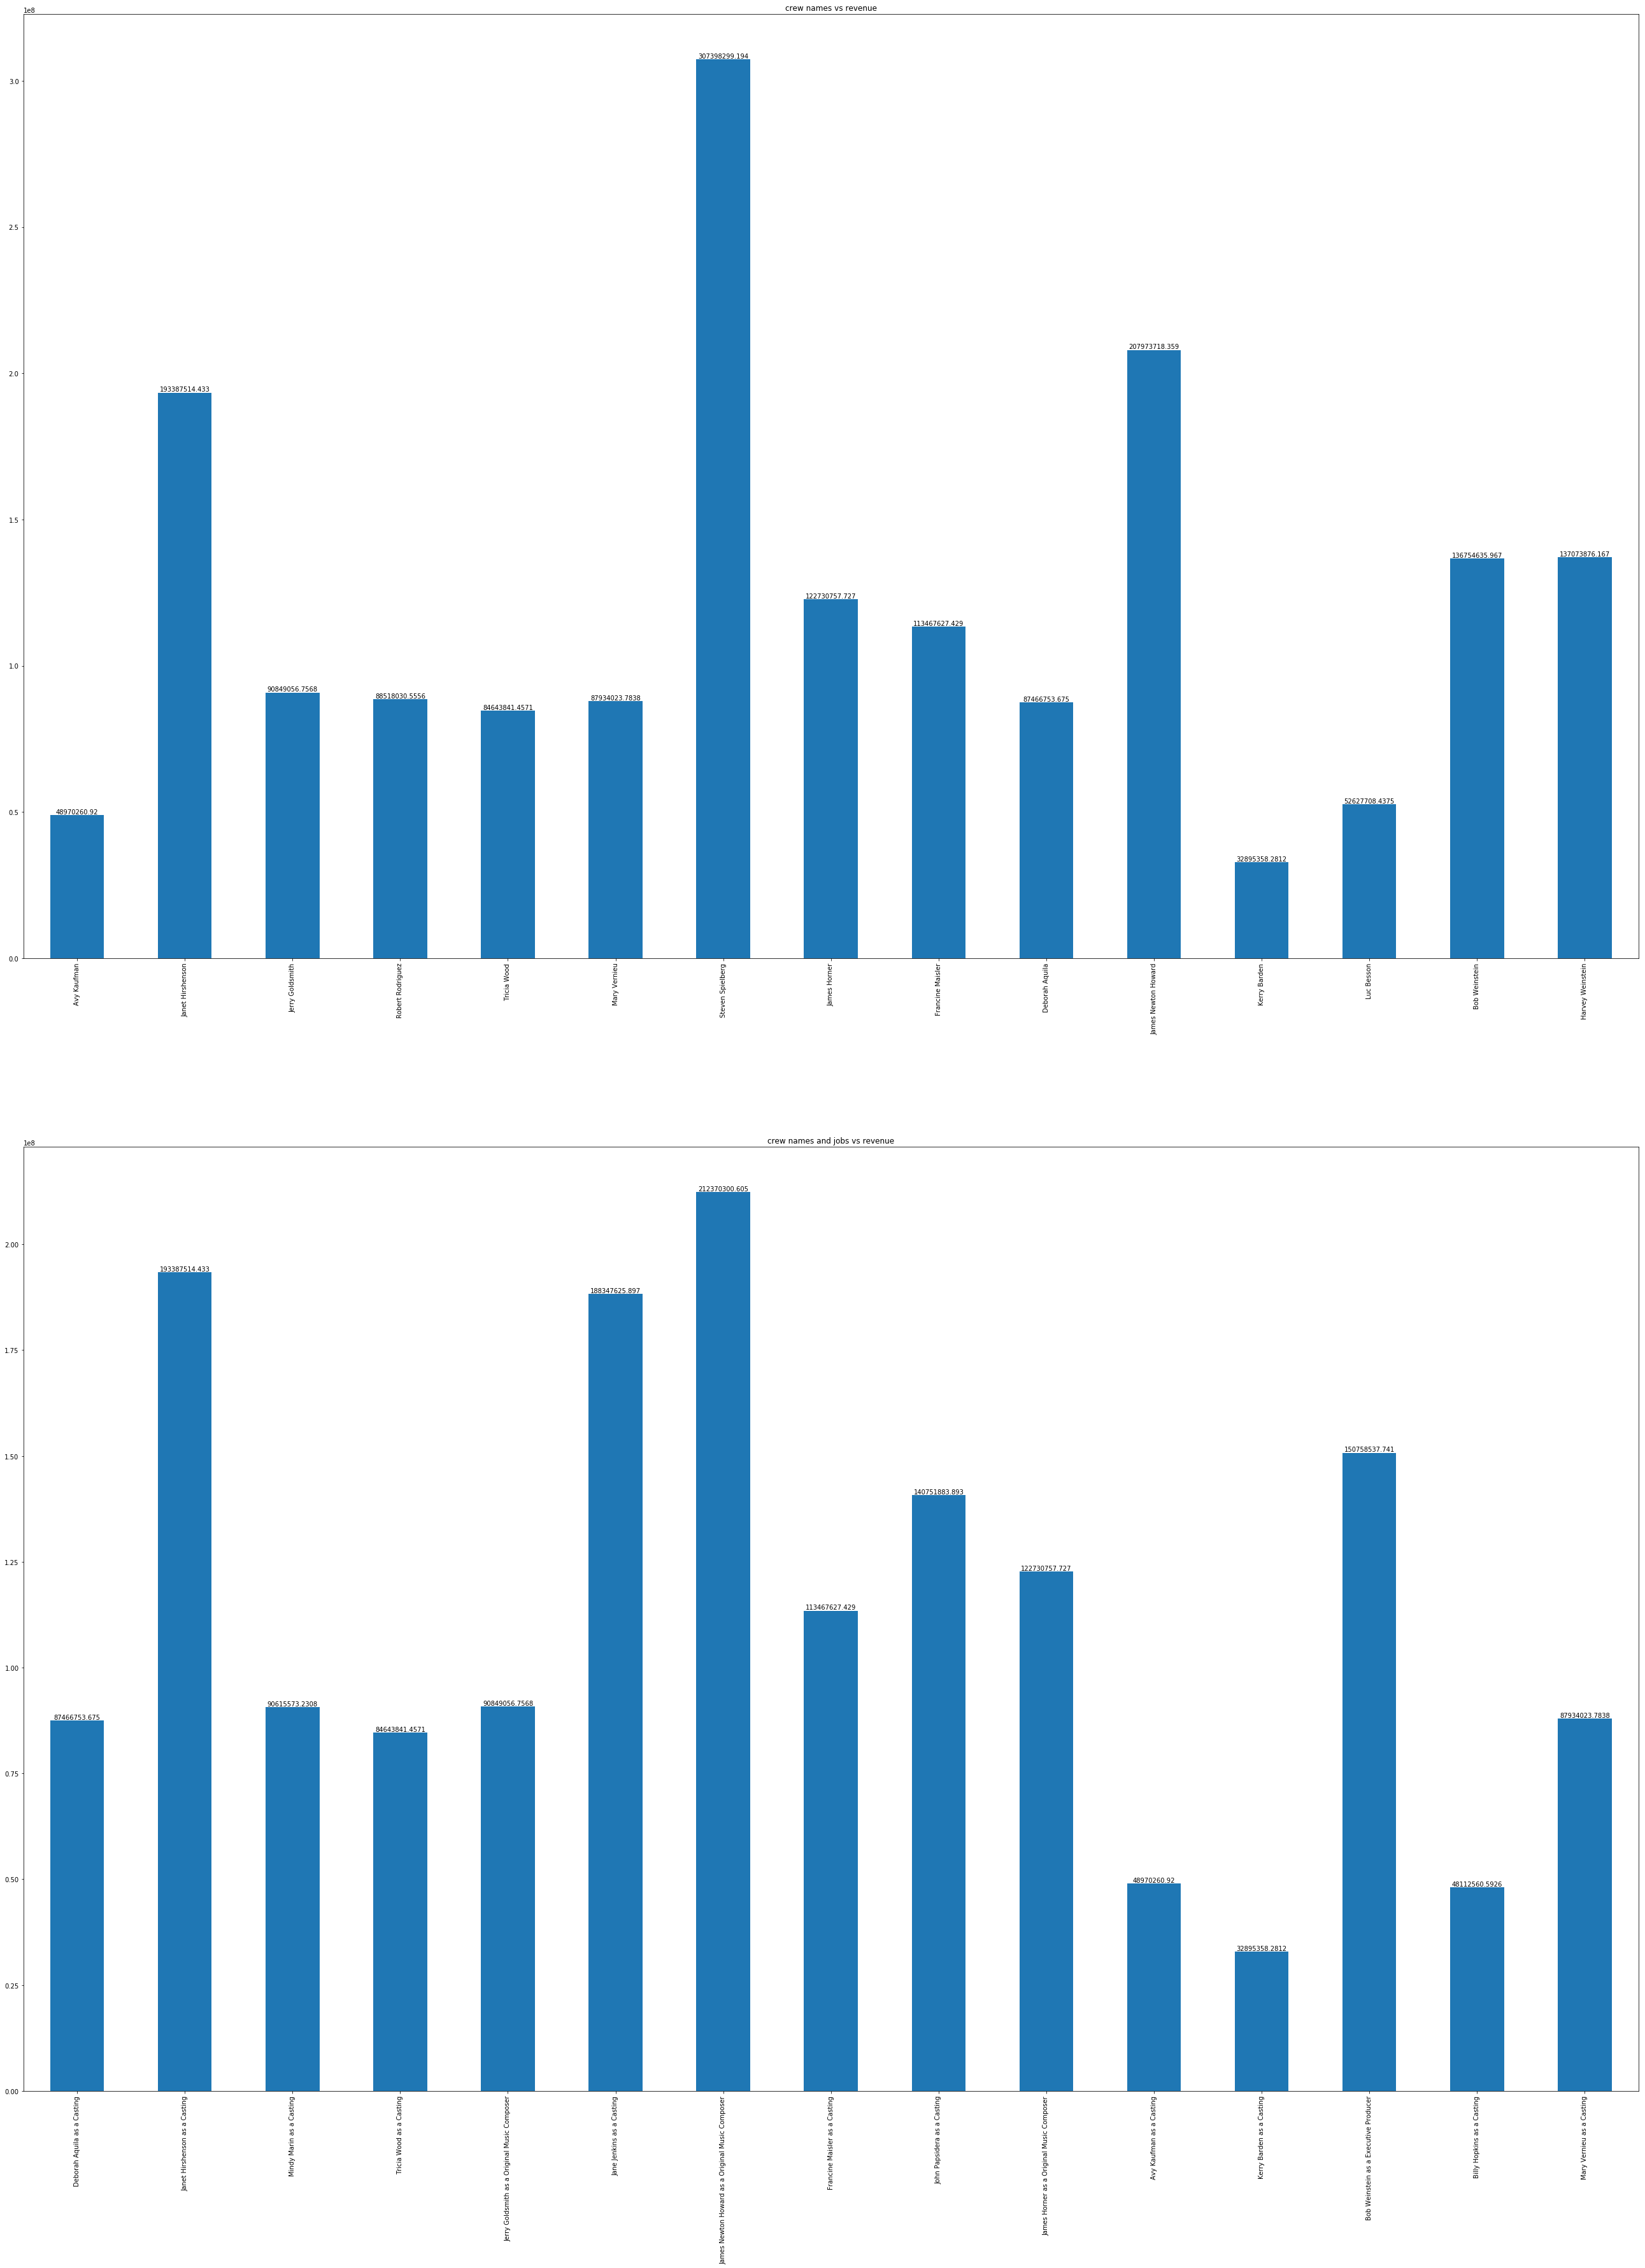

In [57]:
means_names={}
means_names_jobs = {}
for g in popular_crew_names:
    f = 'crew_name_' + g
    means_names[g] = mean(list(train_set.loc[train_set[f] > 0]["revenue"]))

for (name, job) in popular_crew_names_jobs:
    f = "crew_name_"+name+"_job_"+job
    means_names_jobs[name+" as a "+job] =  mean(list(train_set.loc[train_set[f] > 0]["revenue"]))

plt.figure(figsize=(100, 60))
plt.subplot(2, 2, 1)
plt.title("crew names vs revenue")
bar_plot(means_names)
plt.subplot(2,2,3)
plt.title("crew names and jobs vs revenue")
bar_plot(means_names_jobs)
    

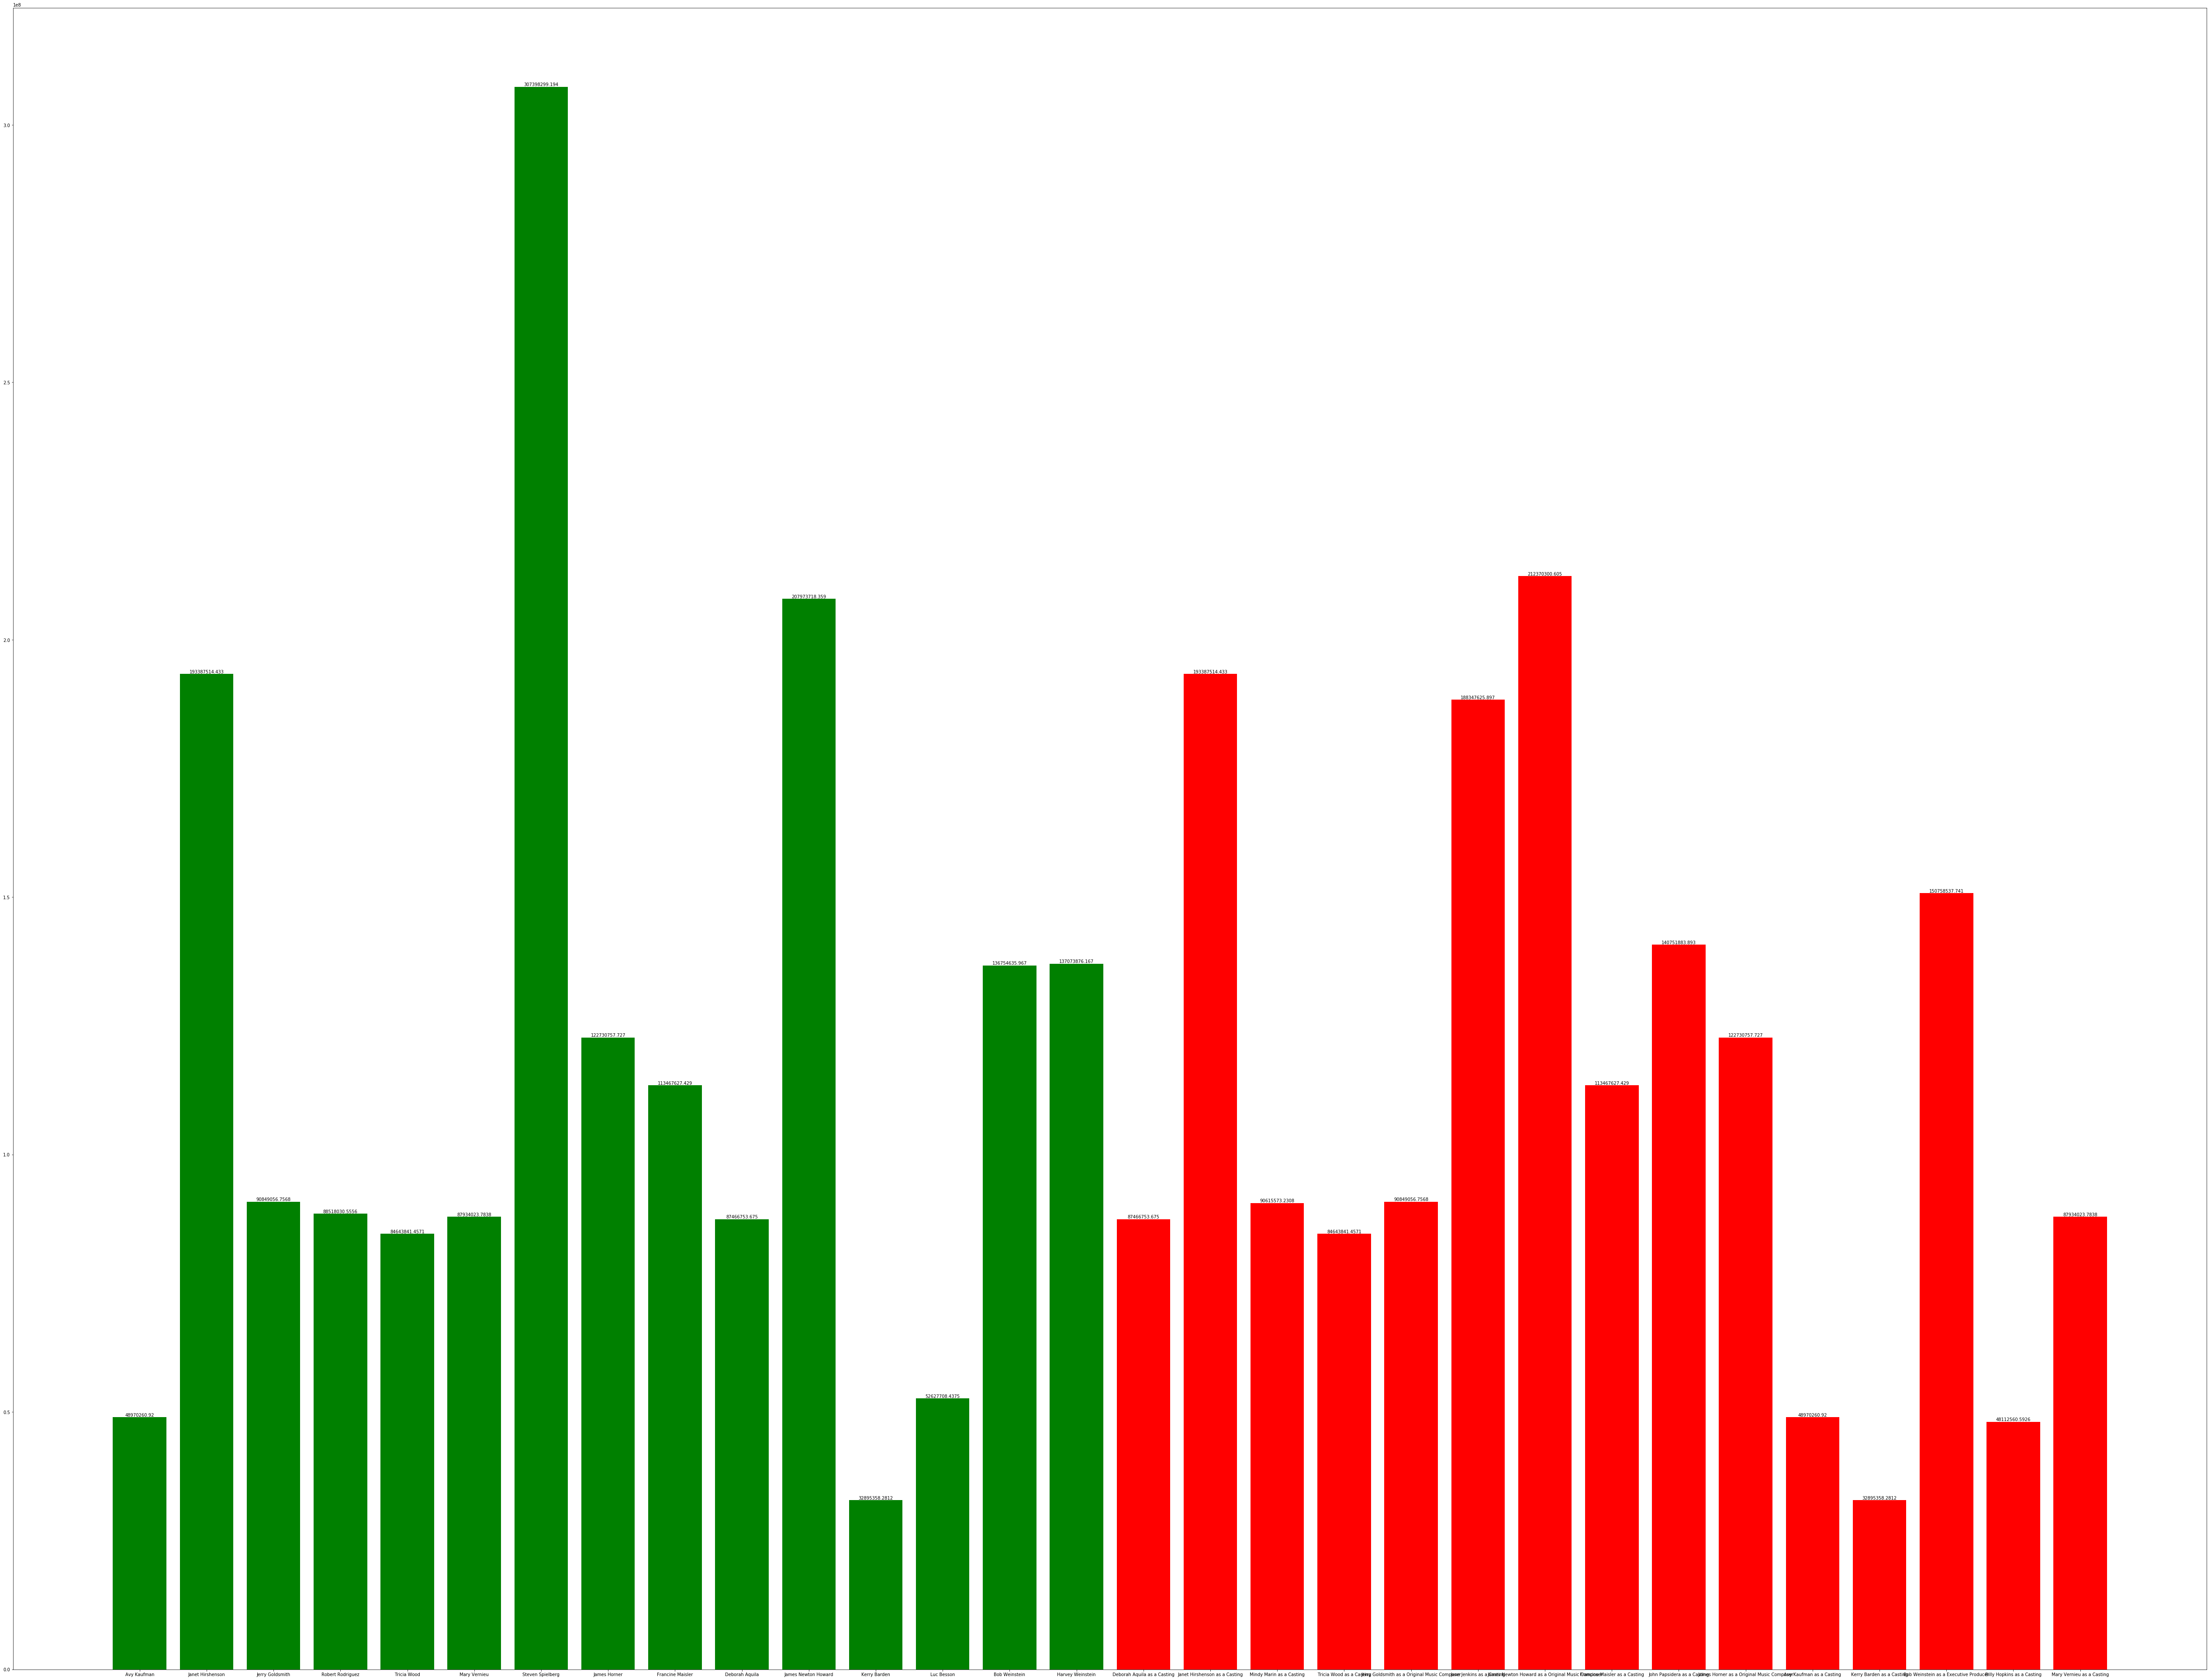

In [58]:
plt.figure(figsize=(90,70))
ax = plt.subplot(111)
ax.bar(means_names.keys(), means_names.values(), color="g")
ax.bar(means_names_jobs.keys(), means_names_jobs.values(), color="r")

rects = ax.patches

for rect, label in zip(rects,  means_names.values()+means_names_jobs.values()):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

There is a noticable difference between the graphs, that is, some popular crew members when tied to a specific job title have a higher potential to boost the movie's revenue than some other popular crew members although they are less popular. to settle for a midground, we will add those crew members that don't appear as popular by their name but by ther name and job title to the feature "crew_name_" remove the feature "crew_name_..._ job _" and add another dummy feature for the jobs alone, and it will as well contain the jobs that appeared before in the feature  "crew_name_..._ job _". This way we haven't lost much information.

In [59]:
crew_jobs = list(train_set["crew"].apply(lambda x: [i["job"] for i in x] if x!= {} else []))
popular_crew_jobs = [a[0] for a in Counter([i for j in crew_jobs for i in j]).most_common(15)]
for job in popular_crew_jobs:
    train_set["crew_job_"+job] = train_set["crew"].apply(lambda x: 1 if job in str(x) else 0)


for (name, job) in popular_crew_names_jobs:
    train_set.drop(["crew_name_"+name+"_job_"+job], axis=1, inplace=True)
    train_set["crew_name_"+name] = train_set["crew"].apply(lambda x: 1 if name in str(x) else 0)
    train_set["crew_job_"+job] = train_set["crew"].apply(lambda x: 1 if job in str(x) else 0)
    
train_set

id     budget                                           homepage  \
0        1   14000000                                                NaN   
1        2   40000000                                                NaN   
2        3    3300000                  http://sonyclassics.com/whiplash/   
3        4    1200000                         http://kahaanithefilm.com/   
4        5          0                                                NaN   
5        6    8000000                                                NaN   
6        7   14000000                 http://www.thepossessionmovie.com/   
7        8          0                                                NaN   
8        9          0                                                NaN   
9       10    6000000                                                NaN   
10      11    1000000                                                NaN   
11      12          0                                                NaN   
12      13   15000000                      http://www.dreamworks.com/ab/   
13      14   53000000                                                NaN   
14      15  102000000                                                NaN   
15      16     500000              http://skinningmovie.com/synopsis.htm   
16      17   26000000                                                NaN   
17      18          0                                                NaN   
18      19    8000000                                                NaN   
19      20   32000000                                                NaN   
20      21   80000000                                                NaN   
21      22    4000000                                                NaN   
22      23          0                http://www.magnetreleasing.com/vhs/   
23      24          0                        http://insightthemovie.com/   
24      25          0                http://www.blacksheep-themovie.com/   
25      26          0                                                NaN   
26      27   10000000                                                NaN   
27      28   11000000                                                NaN   
28      29    6000000                                                NaN   
29      30   45000000                                                NaN   
...    ...        ...                                                ...   
2970  2971   25000000                                                NaN   
2971  2972   20000000                                                NaN   
2972  2973          0                                                NaN   
2973  2974          0                                                NaN   
2974  2975   20000000                                                NaN   
2975  2976   45000000              http://www.aliensintheatticmovie.com/   
2976  2977   16000000                                                NaN   
2977  2978   53000000  http://angeleyesmovie.warnerbros.com/index_nof...   
2978  2979          0                                                NaN   
2979  2980   35000000                     http://www.theback-upplan.com/   
2980  2981     300000           https://www.facebook.com/Actionherobiju/   
2981  2982          0                                                NaN   
2982  2983     500000                                                NaN   
2983  2984   35000000                                                NaN   
2984  2985   80000000        http://www.sonypictures.com/homevideo/swat/   
2985  2986   37665000  http://www.sonypictures.com/homevideo/freedoml...   
2986  2987   20000000                                                NaN   
2987  2988          0                                                NaN   
2988  2989          0                                                NaN   
2989  2990          0                                                NaN   
2990  2991          0                                   

In [60]:
for name in popular_crew_names:
    test_set["crew_name_"+name] = test_set["crew"].apply(lambda x: 1 if name in str(x) else 0)


for job in popular_crew_jobs:
    test_set["crew_job_"+job] = test_set["crew"].apply(lambda x: 1 if job in str(x) else 0)


for (name, job) in popular_crew_names_jobs:
    test_set["crew_name_"+name] = test_set["crew"].apply(lambda x: 1 if name in str(x) else 0)
    test_set["crew_job_"+job] = test_set["crew"].apply(lambda x: 1 if job in str(x) else 0)

In [61]:
train_set['total_crew_members'] = train_set['crew'].apply(lambda x: len(x) if x != {} else 0)
test_set['total_crew_members'] = test_set['crew'].apply(lambda x: len(x) if x != {} else 0)

train_set["crew_male_percentage"] = train_set['crew'].apply(lambda x: 0 if len(x)==0 else float(len([i for i in x if i["gender"] == 2]))/len(x))
train_set["crew_female_percentage"] = train_set['crew'].apply(lambda x: 0 if len(x)==0 else float(len([i for i in x if i["gender"] == 1]))/len(x))
train_set["crew_unspecified_percentage"] = train_set['crew'].apply(lambda x: 0 if len(x)==0 else float(len([i for i in x if i["gender"] == 0]))/len(x))



test_set["crew_male_percentage"] = test_set['crew'].apply(lambda x: 0 if len(x)==0 else float(len([i for i in x if i["gender"] == 2]))/len(x))
test_set["crew_female_percentage"] = test_set['crew'].apply(lambda x: 0 if len(x)==0 else float(len([i for i in x if i["gender"] == 1]))/len(x))
test_set["crew_unspecified_percentage"] = test_set['crew'].apply(lambda x: 0 if len(x)==0 else float(len([i for i in x if i["gender"] == 0]))/len(x))

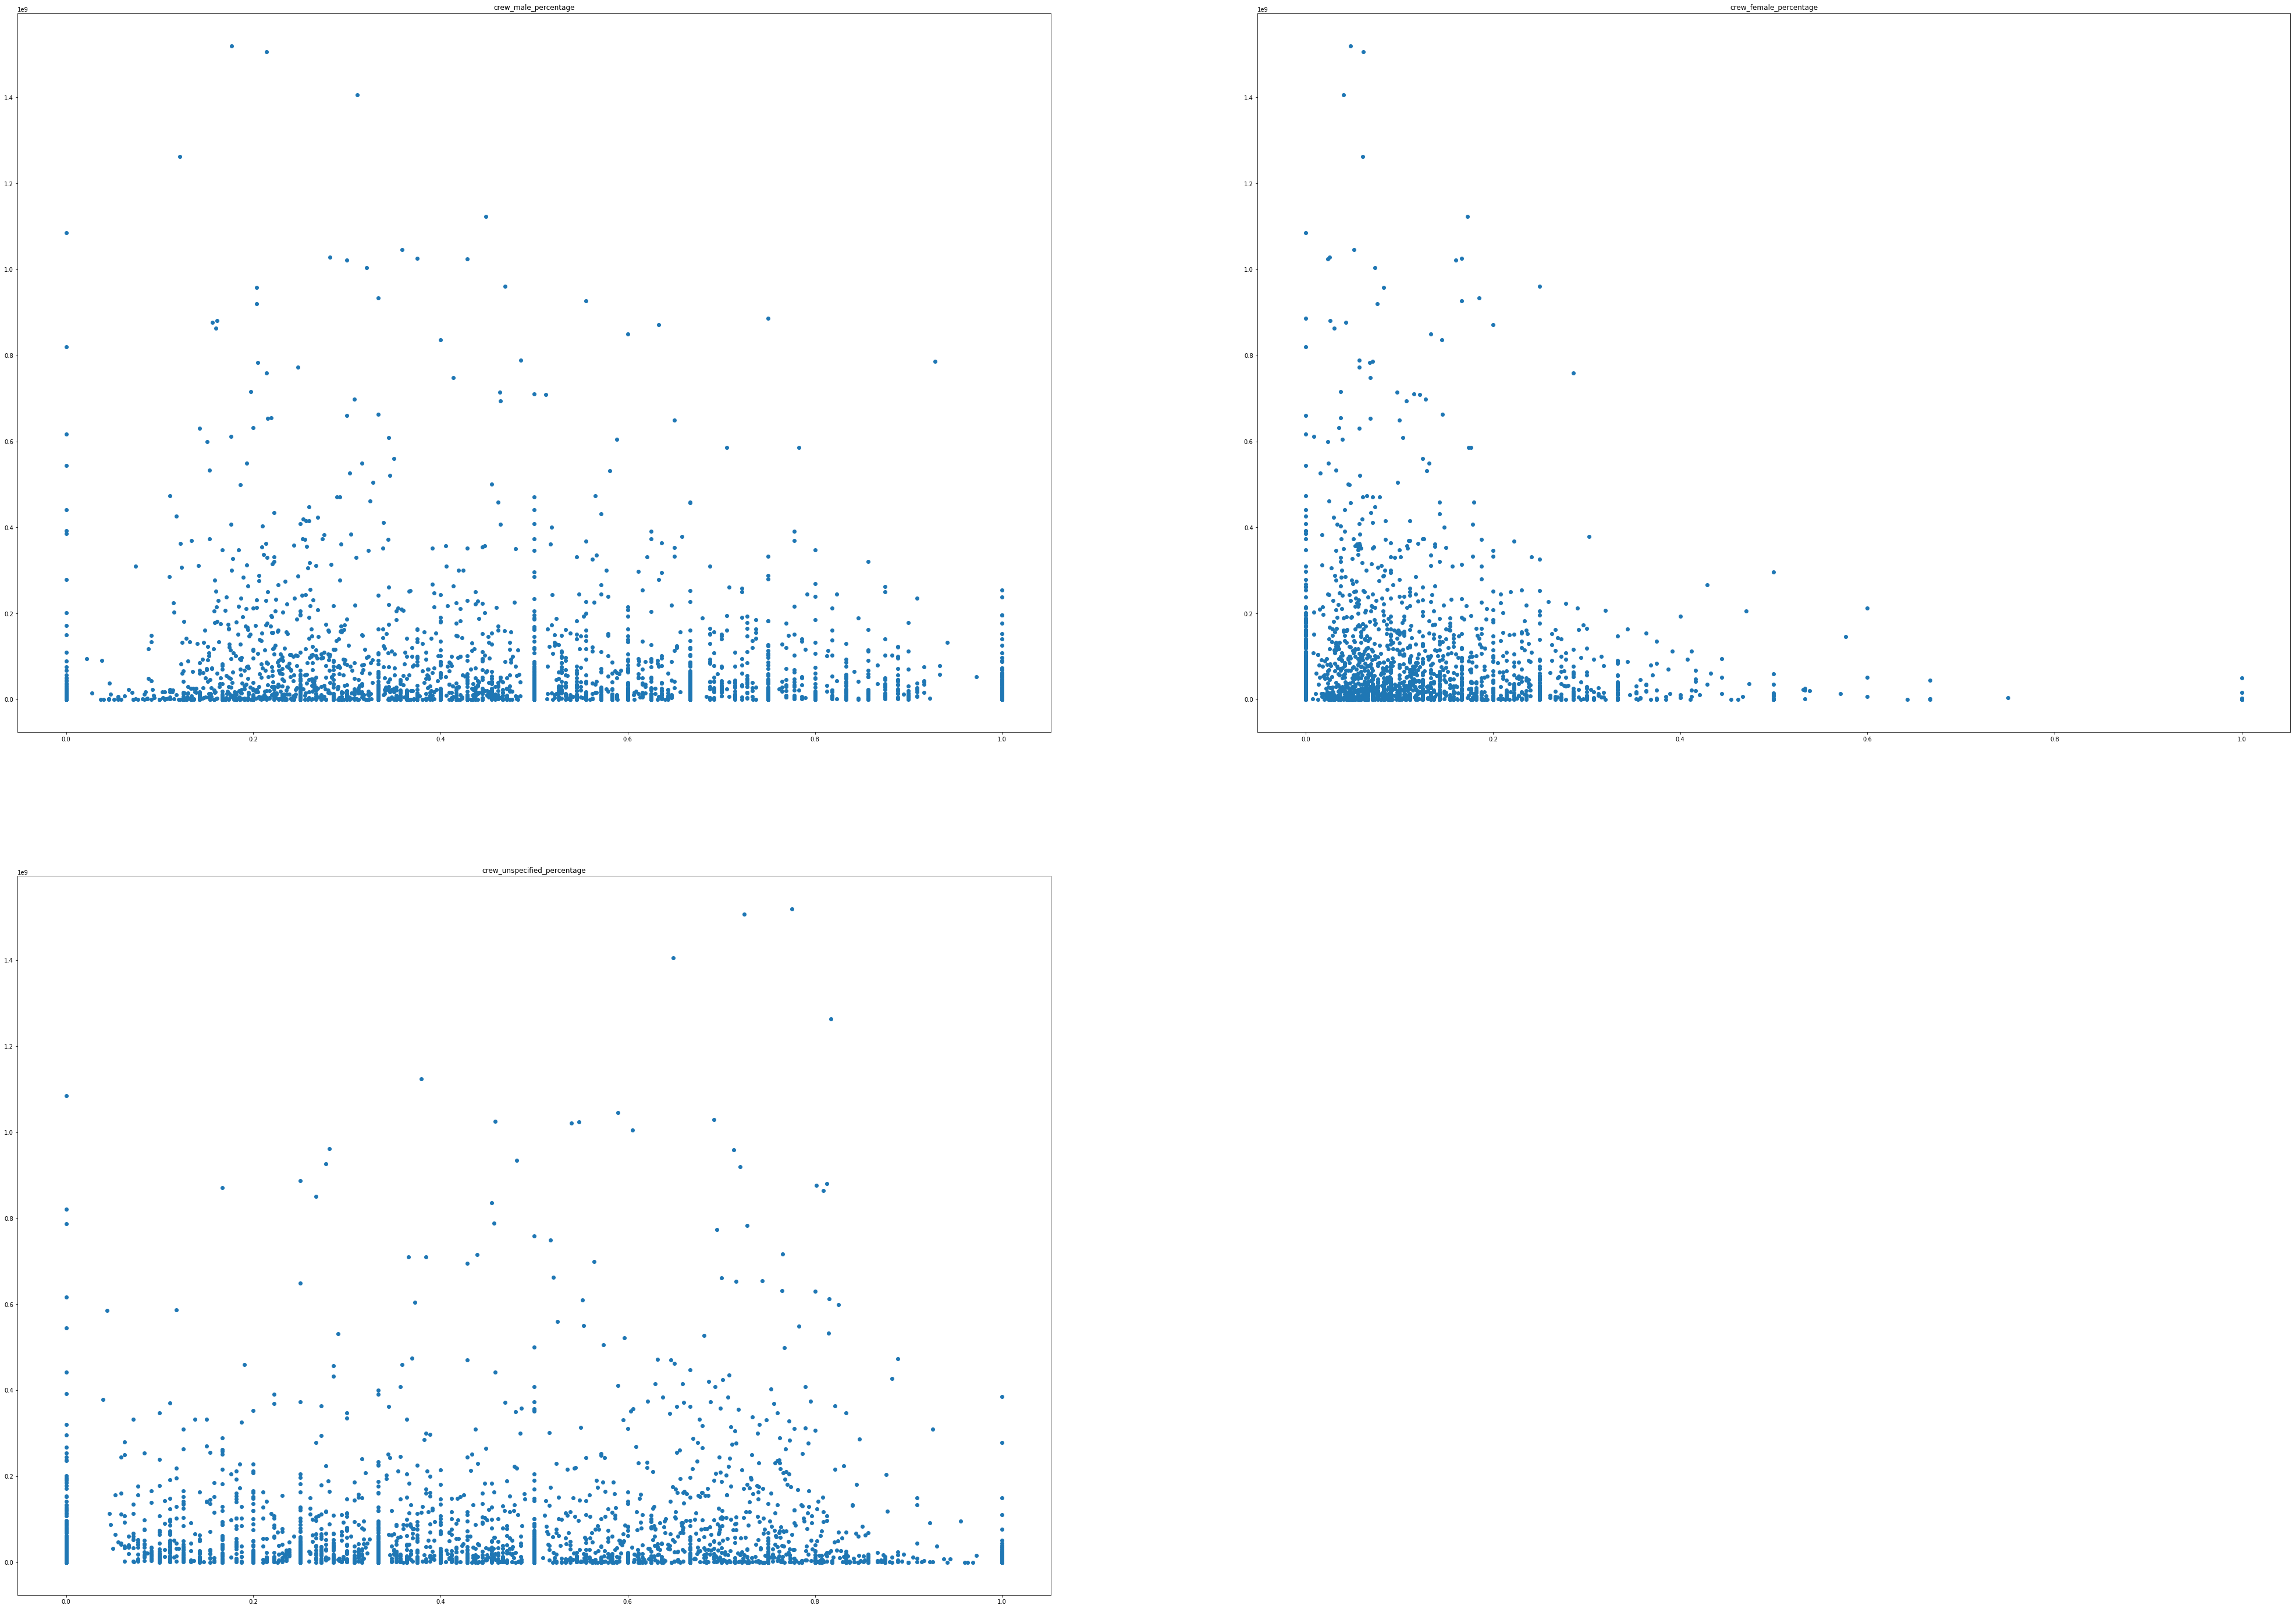

In [62]:
plt.figure(figsize=(70,50))
plt.subplot(2,2,1)
plt.title("crew_male_percentage")
plt.scatter(train_set['crew_male_percentage'], train_set['revenue'])
plt.subplot(2,2,2)
plt.title("crew_female_percentage")
plt.scatter(train_set['crew_female_percentage'], train_set['revenue'])
plt.subplot(2,2,3)
plt.title("crew_unspecified_percentage")
plt.scatter(train_set['crew_unspecified_percentage'], train_set['revenue'])

### production_companies feature


In [63]:
train_set["production_companies"][0]

[{'id': 4, 'name': 'Paramount Pictures'},
 {'id': 60, 'name': 'United Artists'},
 {'id': 8411, 'name': 'Metro-Goldwyn-Mayer (MGM)'}]

we are familiar with this type of features...

In [64]:
companies = list(train_set['production_companies'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
popular_companies = [m[0] for m in Counter([i for j in companies for i in j]).most_common(30)]
for c in popular_companies:
    train_set["production_company_"+c] = train_set["production_companies"].apply(lambda x: 1 if c in str(x) else 0)
    test_set["production_company_"+c] = test_set["production_companies"].apply(lambda x: 1 if c in str(x) else 0)

train_set["num_production_companies"] = train_set["production_companies"].apply(lambda x: len(x))
test_set["num_production_companies"] = test_set["production_companies"].apply(lambda x: len(x))

train_set.drop(["production_companies"], axis=1, inplace=True)
test_set.drop(["production_companies"], axis=1, inplace=True)

In [65]:
train_set

id     budget                                           homepage  \
0        1   14000000                                                NaN   
1        2   40000000                                                NaN   
2        3    3300000                  http://sonyclassics.com/whiplash/   
3        4    1200000                         http://kahaanithefilm.com/   
4        5          0                                                NaN   
5        6    8000000                                                NaN   
6        7   14000000                 http://www.thepossessionmovie.com/   
7        8          0                                                NaN   
8        9          0                                                NaN   
9       10    6000000                                                NaN   
10      11    1000000                                                NaN   
11      12          0                                                NaN   
12      13   15000000                      http://www.dreamworks.com/ab/   
13      14   53000000                                                NaN   
14      15  102000000                                                NaN   
15      16     500000              http://skinningmovie.com/synopsis.htm   
16      17   26000000                                                NaN   
17      18          0                                                NaN   
18      19    8000000                                                NaN   
19      20   32000000                                                NaN   
20      21   80000000                                                NaN   
21      22    4000000                                                NaN   
22      23          0                http://www.magnetreleasing.com/vhs/   
23      24          0                        http://insightthemovie.com/   
24      25          0                http://www.blacksheep-themovie.com/   
25      26          0                                                NaN   
26      27   10000000                                                NaN   
27      28   11000000                                                NaN   
28      29    6000000                                                NaN   
29      30   45000000                                                NaN   
...    ...        ...                                                ...   
2970  2971   25000000                                                NaN   
2971  2972   20000000                                                NaN   
2972  2973          0                                                NaN   
2973  2974          0                                                NaN   
2974  2975   20000000                                                NaN   
2975  2976   45000000              http://www.aliensintheatticmovie.com/   
2976  2977   16000000                                                NaN   
2977  2978   53000000  http://angeleyesmovie.warnerbros.com/index_nof...   
2978  2979          0                                                NaN   
2979  2980   35000000                     http://www.theback-upplan.com/   
2980  2981     300000           https://www.facebook.com/Actionherobiju/   
2981  2982          0                                                NaN   
2982  2983     500000                                                NaN   
2983  2984   35000000                                                NaN   
2984  2985   80000000        http://www.sonypictures.com/homevideo/swat/   
2985  2986   37665000  http://www.sonypictures.com/homevideo/freedoml...   
2986  2987   20000000                                                NaN   
2987  2988          0                                                NaN   
2988  2989          0                                                NaN   
2989  2990          0                                                NaN   
2990  2991          0                                   

### production_countries feature



In [66]:
train_set["production_countries"][0]

[{'iso_3166_1': 'US', 'name': 'United States of America'}]

Much of the same...

In [67]:
countries = list(train_set['production_countries'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
popular_countries = [m[0] for m in Counter([i for j in countries for i in j]).most_common(30)]
for c in popular_countries:
    train_set["production_country"+c] = train_set["production_countries"].apply(lambda x: 1 if c in str(x) else 0)
    test_set["production_country_"+c] = test_set["production_countries"].apply(lambda x: 1 if c in str(x) else 0)

train_set["num_production_countries"] = train_set["production_countries"].apply(lambda x: len(x))
test_set["num_production_countries"] = test_set["production_countries"].apply(lambda x: len(x))

train_set.drop(["production_countries"], axis=1, inplace=True)
test_set.drop(["production_countries"], axis=1, inplace=True)

In [68]:
train_set

id     budget                                           homepage  \
0        1   14000000                                                NaN   
1        2   40000000                                                NaN   
2        3    3300000                  http://sonyclassics.com/whiplash/   
3        4    1200000                         http://kahaanithefilm.com/   
4        5          0                                                NaN   
5        6    8000000                                                NaN   
6        7   14000000                 http://www.thepossessionmovie.com/   
7        8          0                                                NaN   
8        9          0                                                NaN   
9       10    6000000                                                NaN   
10      11    1000000                                                NaN   
11      12          0                                                NaN   
12      13   15000000                      http://www.dreamworks.com/ab/   
13      14   53000000                                                NaN   
14      15  102000000                                                NaN   
15      16     500000              http://skinningmovie.com/synopsis.htm   
16      17   26000000                                                NaN   
17      18          0                                                NaN   
18      19    8000000                                                NaN   
19      20   32000000                                                NaN   
20      21   80000000                                                NaN   
21      22    4000000                                                NaN   
22      23          0                http://www.magnetreleasing.com/vhs/   
23      24          0                        http://insightthemovie.com/   
24      25          0                http://www.blacksheep-themovie.com/   
25      26          0                                                NaN   
26      27   10000000                                                NaN   
27      28   11000000                                                NaN   
28      29    6000000                                                NaN   
29      30   45000000                                                NaN   
...    ...        ...                                                ...   
2970  2971   25000000                                                NaN   
2971  2972   20000000                                                NaN   
2972  2973          0                                                NaN   
2973  2974          0                                                NaN   
2974  2975   20000000                                                NaN   
2975  2976   45000000              http://www.aliensintheatticmovie.com/   
2976  2977   16000000                                                NaN   
2977  2978   53000000  http://angeleyesmovie.warnerbros.com/index_nof...   
2978  2979          0                                                NaN   
2979  2980   35000000                     http://www.theback-upplan.com/   
2980  2981     300000           https://www.facebook.com/Actionherobiju/   
2981  2982          0                                                NaN   
2982  2983     500000                                                NaN   
2983  2984   35000000                                                NaN   
2984  2985   80000000        http://www.sonypictures.com/homevideo/swat/   
2985  2986   37665000  http://www.sonypictures.com/homevideo/freedoml...   
2986  2987   20000000                                                NaN   
2987  2988          0                                                NaN   
2988  2989          0                                                NaN   
2989  2990          0                                                NaN   
2990  2991          0                                   

### homepage feature

In [69]:
train_set["homepage"]

0                                                     NaN
1                                                     NaN
2                       http://sonyclassics.com/whiplash/
3                              http://kahaanithefilm.com/
4                                                     NaN
5                                                     NaN
6                      http://www.thepossessionmovie.com/
7                                                     NaN
8                                                     NaN
9                                                     NaN
10                                                    NaN
11                                                    NaN
12                          http://www.dreamworks.com/ab/
13                                                    NaN
14                                                    NaN
15                  http://skinningmovie.com/synopsis.htm
16                                                    NaN
17            

In [70]:
train_set['has_homepage'] = 0
train_set.loc[train_set['homepage'].isnull() == False, 'has_homepage'] = 1
test_set['has_homepage'] = 0
test_set.loc[test_set['homepage'].isnull() == False, 'has_homepage'] = 1


In [71]:
train_set.drop(["homepage"], axis=1, inplace=True)
test_set.drop(["homepage"], axis=1, inplace=True)
train_set

id     budget    imdb_id original_language  \
0        1   14000000  tt2637294                en   
1        2   40000000  tt0368933                en   
2        3    3300000  tt2582802                en   
3        4    1200000  tt1821480                hi   
4        5          0  tt1380152                ko   
5        6    8000000  tt0093743                en   
6        7   14000000  tt0431021                en   
7        8          0  tt0391024                en   
8        9          0  tt0117110                en   
9       10    6000000  tt0310281                en   
10      11    1000000  tt0075148                en   
11      12          0  tt0093857                en   
12      13   15000000  tt0169547                en   
13      14   53000000  tt0377471                en   
14      15  102000000  tt0181689                en   
15      16     500000  tt1129437                sr   
16      17   26000000  tt0421239                en   
17      18          0  tt1700845                en   
18      19    8000000  tt1487118                en   
19      20   32000000  tt0388482                en   
20      21   80000000  tt0120738                en   
21      22    4000000  tt0083972                en   
22      23          0  tt2105044                en   
23      24          0  tt1687277                en   
24      25          0  tt0779982                en   
25      26          0  tt0104139                en   
26      27   10000000  tt0120176                en   
27      28   11000000  tt1486834                en   
28      29    6000000  tt0092106                en   
29      30   45000000  tt0264472                en   
...    ...        ...        ...               ...   
2970  2971   25000000  tt0103855                en   
2971  2972   20000000  tt0100201                en   
2972  2973          0  tt0482930                cn   
2973  2974          0  tt0089652                en   
2974  2975   20000000  tt0369226                en   
2975  2976   45000000  tt0775552                en   
2976  2977   16000000  tt0186045                en   
2977  2978   53000000  tt0225071                en   
2978  2979          0  tt0120879                en   
2979  2980   35000000  tt1212436                en   
2980  2981     300000  tt5320514                ml   
2981  2982          0  tt4158876                en   
2982  2983     500000  tt2063781                en   
2983  2984   35000000  tt0118623                en   
2984  2985   80000000  tt0257076                en   
2985  2986   37665000  tt0349467                en   
2986  2987   20000000  tt0338325                en   
2987  2988          0  tt0096246                en   
2988  2989          0  tt0301978                fa   
2989  2990          0  tt0206367                en   
2990  2991          0  tt0118663                en   
2991  2992   13000000  tt0206275                en   
2992  2993    1135654  tt0015400                en   
2993  2994   60000000  tt0362227                en   
2994  2995          0  tt0105327                en   
2995  2996          0  tt0109403                en   
2996  2997          0  tt2364975                sv   
2997  2998   65000000  tt0116908                en   
2998  2999   42000000  tt0343135                en   
2999  3000   35000000  tt1600195                en   

                                  original_title  \
0                         Hot Tub Time Machine 2   
1       The Princess Diaries 2: Royal Engagement   
2                                       Whiplash   
3                                        Kahaani   
4                                           마린보이   
5         Pinocchio and the Emperor of the Night   
6                                 The Possession   
7                                   Control Room   
8                         Muppet Treasure Island   
9                                  A Mighty Wind   
10                                         Rocky   
11    Revenge of the Nerds II: Nerd

### release date feature

In [72]:
train_set["release_date"]

0        2/20/15
1         8/6/04
2       10/10/14
3         3/9/12
4         2/5/09
5         8/6/87
6        8/30/12
7        1/15/04
8        2/16/96
9        4/16/03
10      11/21/76
11       7/10/87
12       9/15/99
13        3/4/05
14       6/20/02
15       10/6/10
16        8/4/05
17      12/25/13
18        2/2/11
19        8/2/05
20        4/3/98
21       8/13/82
22       7/28/12
23        9/2/11
24        9/9/06
25      10/23/92
26        9/8/97
27        9/7/13
28        8/8/86
29        4/7/02
          ...   
2970    11/25/92
2971    10/12/90
2972     7/27/06
2973      8/9/85
2974     1/28/05
2975     7/31/09
2976      3/3/00
2977     5/15/01
2978    10/23/98
2979     4/23/10
2980      2/4/16
2981      9/9/16
2982     9/12/12
2983      4/4/97
2984      8/8/03
2985     2/17/06
2986      9/3/04
2987     1/20/89
2988     5/20/02
2989     5/11/01
2990     3/28/97
2991     1/12/01
2992     3/18/24
2993     6/17/04
2994     9/18/92
2995     4/22/94
2996     3/28/13
2997    10/11/

In [73]:
test_set.loc[test_set['release_date'].isnull() == True, 'release_date'] = '01/05/00'

#####DEAL with this!!!????!?!?!?!??!!?!?!?!?!?!??!?!!?!??

We will seperate the release date into seperate features to des ribe the day, month, year, weekday and maybe others, as suplied by the data type pd.datetime but first, we'll fix the yearsfrom two digits to 4:

In [74]:
def fix_year(date):
    year = date.split("/")[2]
    if year.startswith("0") or year.startswith("1"):
        year = "20"+year
    else: 
        year = "19"+year
        
    return date[:-2]+year

train_set["release_date"]= train_set["release_date"].apply(lambda d: fix_year(d))


In [75]:
test_set["release_date"]= test_set["release_date"].apply(lambda d: d if type(d) is not str and math.isnan(d) else fix_year(d))

In [76]:
test_set["release_date"]

0        7/14/2007
1        5/19/1958
2        5/23/1997
3         9/4/2010
4        2/11/2005
5         2/7/1996
6       12/23/2010
7        2/11/2000
8         3/2/2007
9       10/30/1999
10        9/1/2005
11       6/27/2014
12       9/10/1980
13       5/16/2002
14        9/9/2008
15       9/12/2010
16       3/26/2010
17       4/16/2014
18      12/20/1979
19      11/18/1997
20       9/11/1998
21       9/19/2008
22        9/8/2006
23       8/27/2004
24       4/15/2016
25      11/15/1991
26        7/6/1988
27      10/14/2016
28       5/16/2012
29       8/17/2001
           ...    
4368      1/1/2016
4369     3/14/2008
4370    10/15/1999
4371    11/23/2010
4372    11/22/2011
4373     11/3/1976
4374     5/24/1991
4375      9/6/2002
4376     6/22/1970
4377     9/10/2014
4378     9/16/2005
4379     4/30/2015
4380      6/3/2016
4381     3/26/1970
4382    11/23/2006
4383     9/11/2012
4384     8/14/1987
4385    12/21/2001
4386     6/28/1991
4387     9/11/2013
4388     1/30/2006
4389     3/2

In [77]:
train_set['release_date'] = pd.to_datetime(train_set['release_date'])
test_set['release_date'] = pd.to_datetime(test_set['release_date'])
getattr(test_set['release_date'].dt, "weekofyear")

0       28
1       21
2       21
3       35
4        6
5        6
6       51
7        6
8        9
9       43
10      35
11      26
12      37
13      20
14      37
15      36
16      12
17      16
18      51
19      47
20      37
21      38
22      36
23      35
24      15
25      46
26      27
27      41
28      20
29      33
        ..
4368    53
4369    11
4370    41
4371    47
4372    47
4373    45
4374    21
4375    36
4376    26
4377    37
4378    37
4379    18
4380    22
4381    13
4382    47
4383    37
4384    33
4385    51
4386    26
4387    37
4388     5
4389    12
4390    25
4391    45
4392    26
4393    31
4394    34
4395    49
4396     6
4397    38
Name: release_date, Length: 4398, dtype: int64

In [78]:

date_parts = ["year", "month","week", "day", "quarter", "weekday"]
for part in date_parts:
    part_col = 'release_date' + "_" + part
    train_set[part_col] = getattr(train_set['release_date'].dt, part).astype(int)
    test_set[part_col] = getattr(test_set['release_date'].dt, part).astype(int)

In [83]:
import plotly.graph_objs as go
import plotly.offline as py



d1 = train_set['release_date_year'].value_counts().sort_index()
d2 = test_set['release_date_year'].value_counts().sort_index()
data = [go.Scatter(x=d1.index, y=d1.values, name='train'), go.Scatter(x=d2.index, y=d2.values, name='test')]
layout = go.Layout(dict(title = "Number of films per year",
                  xaxis = dict(title = 'Year'),
                  yaxis = dict(title = 'Count'),
                  ),legend=dict(
                orientation="v"))
py.iplot(dict(data=data, layout=layout))

In [84]:
d1 = train_set['release_date_year'].value_counts().sort_index()
d2 = train_set.groupby(['release_date_year'])['revenue'].sum()
data = [go.Scatter(x=d1.index, y=d1.values, name='film count'), go.Scatter(x=d2.index, y=d2.values, name='total revenue', yaxis='y2')]
layout = go.Layout(dict(title = "Number of films and total revenue per year",
                  xaxis = dict(title = 'Year'),
                  yaxis = dict(title = 'Count'),
                  yaxis2=dict(title='Total revenue', overlaying='y', side='right')
                  ),legend=dict(
                orientation="v"))
py.iplot(dict(data=data, layout=layout))

In [85]:
d1 = train_set['release_date_year'].value_counts().sort_index()
d2 = train_set.groupby(['release_date_year'])['revenue'].mean()
data = [go.Scatter(x=d1.index, y=d1.values, name='film count'), go.Scatter(x=d2.index, y=d2.values, name='mean revenue', yaxis='y2')]
layout = go.Layout(dict(title = "Number of films and average revenue per year",
                  xaxis = dict(title = 'Year'),
                  yaxis = dict(title = 'Count'),
                  yaxis2=dict(title='Average revenue', overlaying='y', side='right')
                  ),legend=dict(
                orientation="v"))
py.iplot(dict(data=data, layout=layout))